In [70]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [71]:
from qiskit_experiments.library import RoughDragCal
from qiskit_experiments.calibration_management import (
    Calibrations,
    FixedFrequencyTransmon,
)
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit.providers.fake_provider import FakePerth

# replace this lines with an IBM Quantum backend to run the experiment.
backend = FakePerth()
cals = Calibrations.from_backend(backend, libraries=[FixedFrequencyTransmon()])

# Define the experiment
qubit = 2
cal_drag = RoughDragCal(qubit, cals, schedule_name='sx', backend=backend)

# Enable restless measurements by setting the run options and data processor
cal_drag.enable_restless(rep_delay=1e-6)

print(cal_drag.analysis.options.data_processor)
print(cal_drag.run_options)

DataProcessor(input_key=memory, nodes=[RestlessToCounts(validate=True), Probability(validate=True, outcome=1, alpha_prior=[0.5, 0.5])])
Options(meas_level=<MeasLevel.CLASSIFIED: 2>, rep_delay=1e-06, init_qubits=False, memory=True, meas_return=<MeasReturnType.SINGLE: 'single'>, use_measure_esp=False)


In [72]:
drag_data_restless = cal_drag.run()

Adding a job from a backend (aer_simulator) that is different than the current backend (<qiskit.providers.fake_provider.backends.perth.fake_perth.FakePerth object at 0x7f25be6cb490>). The new backend will be used, but service is not changed if one already exists.
jobs and analysis raised exceptions [Experiment ID: 6c922d66-fa79-431f-9474-d9c6679f1269]:Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/qiskit_experiments/framework/experiment_data.py", line 794, in _add_job_data
    job_result = job.result()

  File "/opt/conda/lib/python3.10/site-packages/qiskit_aer/jobs/utils.py", line 41, in _wrapper
    return func(self, *args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/qiskit_aer/jobs/aerjob.py", line 106, in result
    return self._future.result(timeout=timeout)

  File "/opt/conda/lib/python3.10/concurrent/futures/_base.py", line 451, in result
    return self.__get_result()

  File "/opt/conda/lib/python3.10/concurrent/futures/_bas

In [73]:
from qiskit_experiments.data_processing import (
    DataProcessor,
    Probability,
)

# define a standard data processor.
standard_processor = DataProcessor("counts", [Probability("1")])

cal_drag = RoughDragCal(qubit, cals, schedule_name='sx', backend=backend)
cal_drag.analysis.set_options(data_processor=standard_processor)

# enable restless mode and set override_processor_by_restless to False.
cal_drag.enable_restless(rep_delay=1e-6, override_processor_by_restless=False)

In [74]:
from qiskit import schedule, transpile
from qiskit_experiments.framework import BackendData

dt = BackendData(backend).dt
inst_map = backend.instruction_schedule_map
meas_length = inst_map.get("measure", (qubit, )).duration * dt

# Compute the average duration of all circuits
# Remove measurement instructions
circuits = []
for qc in cal_drag.circuits():
    qc.remove_final_measurements(inplace=True)
    circuits.append(qc)

# Schedule the circuits to obtain the duration of all the gates
executed_circs = transpile(
    circuits,
    backend,
    initial_layout=[qubit],
    scheduling_method="alap",
    **cal_drag.transpile_options.__dict__,
)
durations = [c.duration for c in executed_circs]

tau = sum(durations) * dt / (len(durations))

n_circs = len(cal_drag.circuits())
# can be obtained from backend.default_rep_delay on a backend from qiskit-ibm-provider

delay_s = 0.0025
delay_r = 1e-6  # restless delay
reset = 4e-6  # Estimated reset duration
speed_up = (meas_length + reset + delay_s + tau) / (meas_length + delay_r + tau)
print(f"The QPU will spend {speed_up:.1f}x less time running restless Drag.")

The QPU will spend 1326.1x less time running restless Drag.


In [75]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

In [76]:
import qiskit
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# GHZ State preparation circuit
nq = 2
qc_ghz = qiskit.QuantumCircuit(nq)
qc_ghz.h(0)
qc_ghz.s(0)
for i in range(1, nq):
    qc_ghz.cx(0, i)

# QST Experiment
qstexp1 = StateTomography(qc_ghz)
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.48095703+0.j        , -0.00309245-0.00813802j,
                 0.00065104-0.00537109j,  0.03759766-0.453125j  ],
               [-0.00309245+0.00813802j,  0.01448568+0.j        ,
                 0.00732422+0.00097656j,  0.00260417+0.00048828j],
               [ 0.00065104+0.00537109j,  0.00732422-0.00097656j,
                 0.02067057+0.j        , -0.00211589+0.00065104j],
               [ 0.03759766+0.453125j  ,  0.00260417-0.00048828j,
                -0.00211589-0.00065104j,  0.48388672+0.j        ]],
              dims=(2, 2))
- extra: <7 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: state_fidelity
- value: 0.9355468749999993
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: positive
- value: True
- device_components: ['Q0', 'Q1']
- verified: False


In [77]:
state_result = qstdata1.analysis_results("state")
print(state_result.value)

DensityMatrix([[ 0.48095703+0.j        , -0.00309245-0.00813802j,
                 0.00065104-0.00537109j,  0.03759766-0.453125j  ],
               [-0.00309245+0.00813802j,  0.01448568+0.j        ,
                 0.00732422+0.00097656j,  0.00260417+0.00048828j],
               [ 0.00065104+0.00537109j,  0.00732422-0.00097656j,
                 0.02067057+0.j        , -0.00211589+0.00065104j],
               [ 0.03759766+0.453125j  ,  0.00260417-0.00048828j,
                -0.00211589-0.00065104j,  0.48388672+0.j        ]],
              dims=(2, 2))


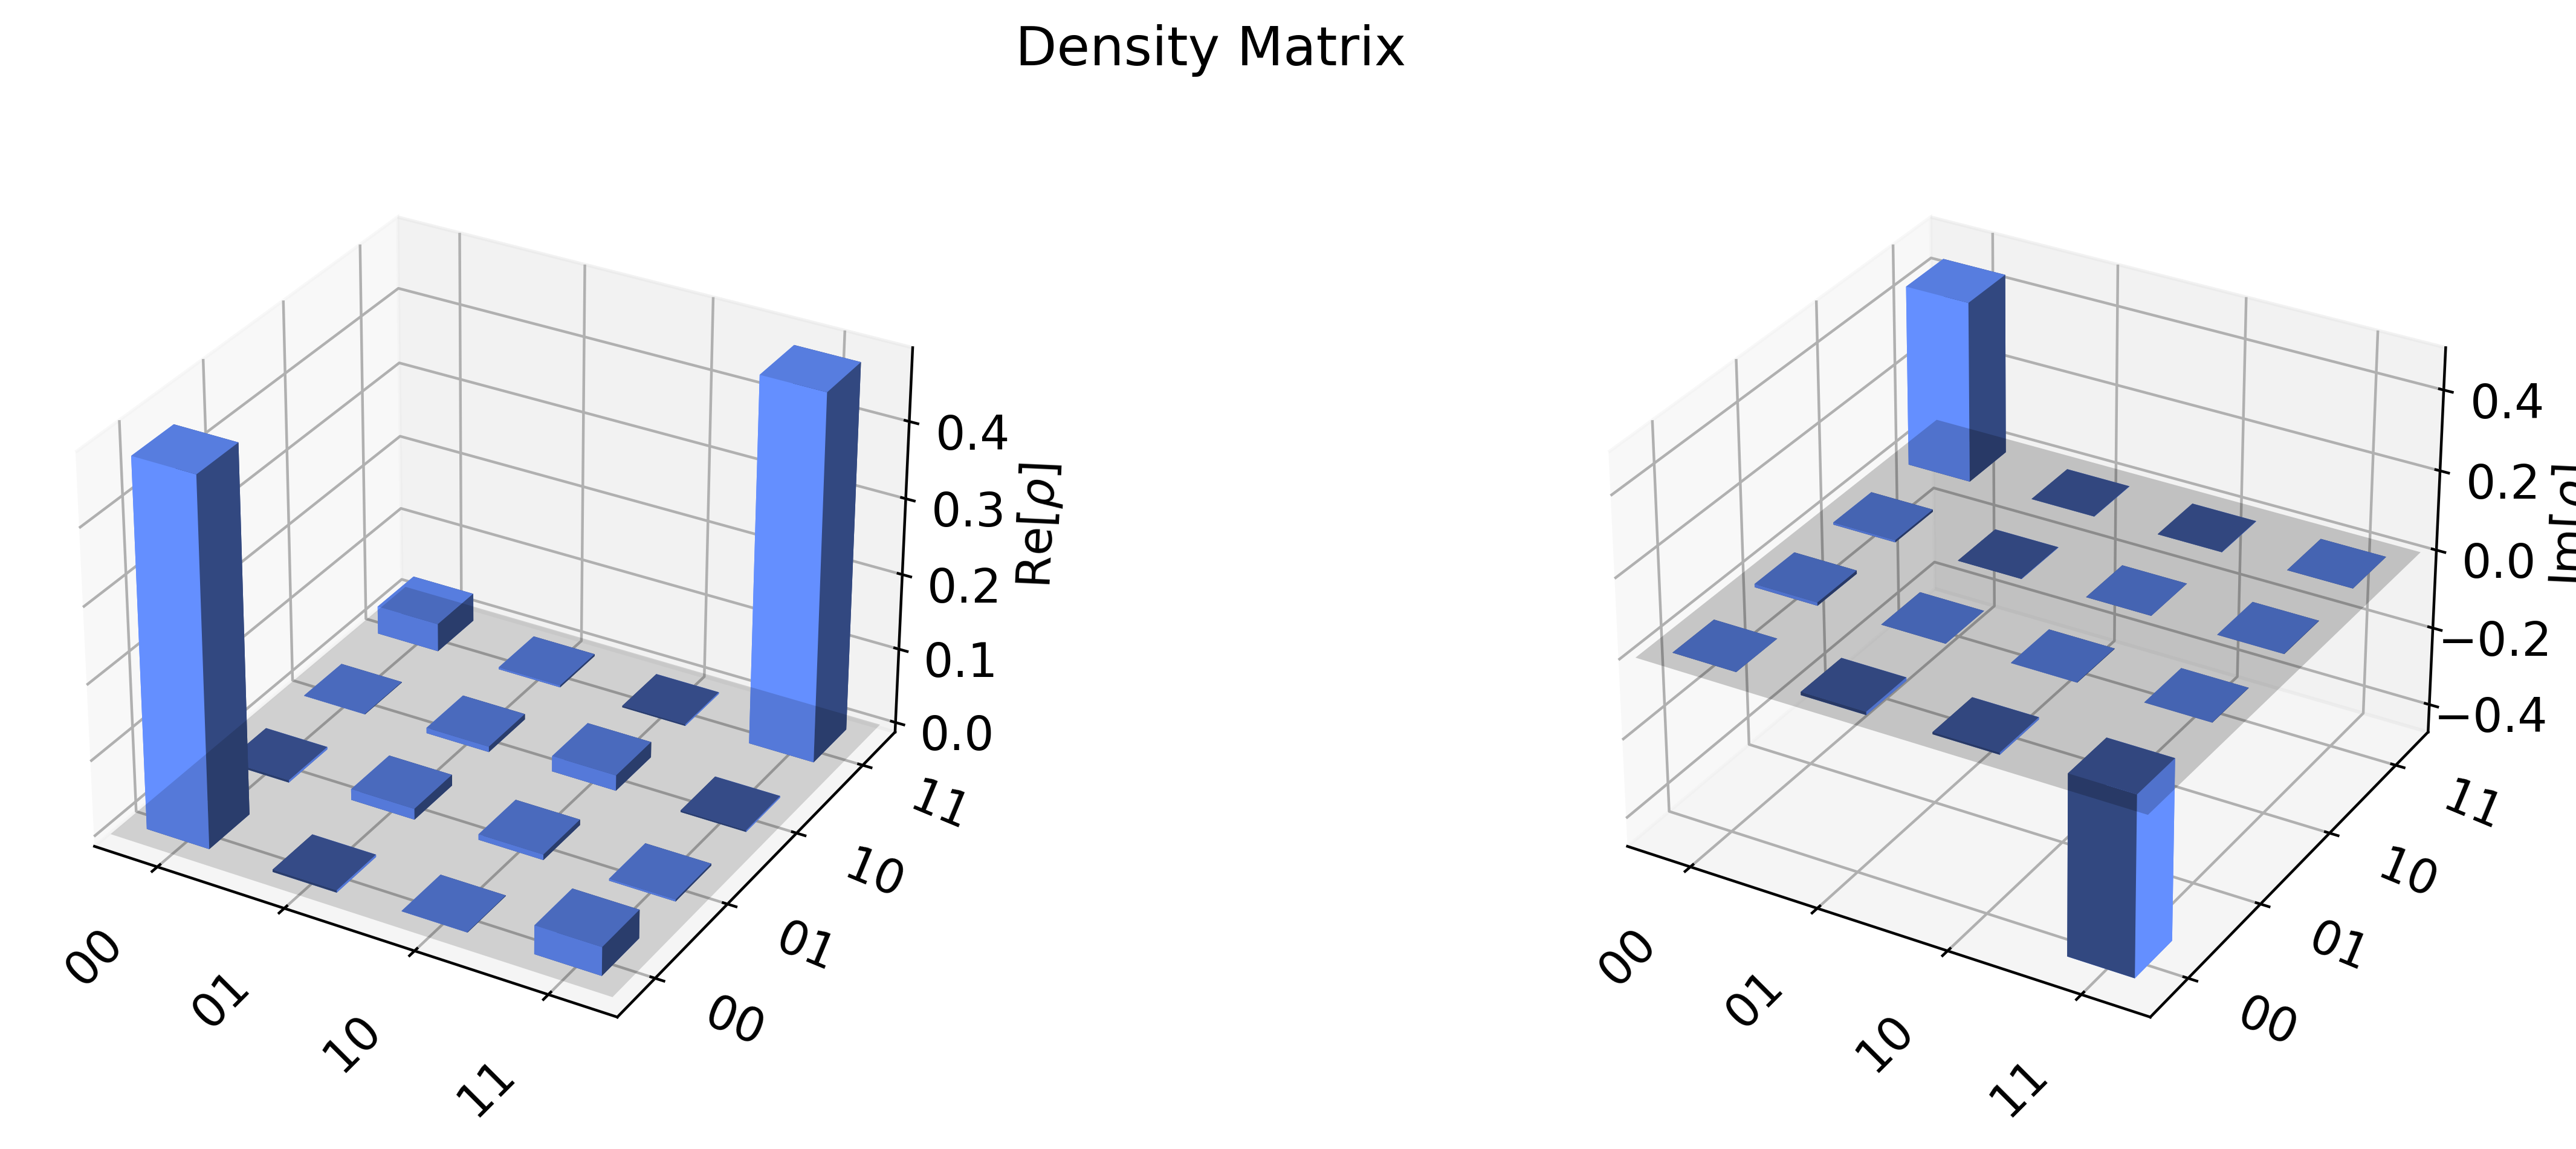

In [78]:
from qiskit.visualization import plot_state_city
plot_state_city(qstdata1.analysis_results("state").value, title='Density Matrix')

In [79]:
fid_result = qstdata1.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result.value))

State Fidelity = 0.93555


In [80]:
state_result.extra

{'trace': 1.0000000000000018,
 'eigvals': array([0.93718159, 0.0334793 , 0.02002704, 0.00931207]),
 'raw_eigvals': array([0.93718159, 0.0334793 , 0.02002704, 0.00931207]),
 'rescaled_psd': False,
 'fitter_metadata': {'fitter': 'linear_inversion',
  'fitter_time': 0.008178234100341797},
 'conditional_probability': 1.0,
 'positive': True}

In [81]:
# QST Experiment
bad_data = qstexp1.run(backend, shots=10, seed_simulation=100).block_for_results()
bad_state_result = bad_data.analysis_results("state")

# Print result
print(bad_state_result)

# Show extra data
bad_state_result.extra

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.49255692+0.j        ,  0.01789044-0.00428116j,
                 0.07414208+0.02891536j,  0.0099503 -0.40416484j],
               [ 0.01789044+0.00428116j,  0.05700264+0.j        ,
                -0.05194199-0.00312306j, -0.0421075 -0.04392031j],
               [ 0.07414208-0.02891536j, -0.05194199+0.00312306j,
                 0.06578774+0.j        ,  0.02468462-0.03703389j],
               [ 0.0099503 +0.40416484j, -0.0421075 +0.04392031j,
                 0.02468462+0.03703389j,  0.3846527 +0.j        ]],
              dims=(2, 2))
- extra: <7 items>
- device_components: ['Q0', 'Q1']
- verified: False


{'trace': 1.0000000000000064,
 'eigvals': array([0.85718909, 0.14281091, 0.        , 0.        ]),
 'raw_eigvals': array([ 0.96933971,  0.25496154,  0.04631009, -0.27061135]),
 'rescaled_psd': True,
 'fitter_metadata': {'fitter': 'linear_inversion',
  'fitter_time': 0.006615400314331055},
 'conditional_probability': 1.0,
 'positive': True}

In [82]:
try:
    import cvxpy

    # Set analysis option for cvxpy fitter
    qstexp1.analysis.set_options(fitter='cvxpy_gaussian_lstsq')

    # Re-run experiment
    qstdata2 = qstexp1.run(backend, seed_simulation=100).block_for_results()

    state_result2 = qstdata2.analysis_results("state")
    print(state_result2)
    print("\nextra:")
    for key, val in state_result2.extra.items():
        print(f"- {key}: {val}")

except ModuleNotFoundError:
    print("CVXPY is not installed")

AnalysisResult
- name: state
- value: DensityMatrix([[ 4.90641356e-01+0.00000000e+00j,
                -6.09810430e-03+1.34204365e-02j,
                -3.48543805e-04-1.20275301e-02j,
                -3.41433420e-03-4.58626617e-01j],
               [-6.09810430e-03-1.34204365e-02j,
                 2.19424398e-02+0.00000000e+00j,
                -2.15267677e-02+1.74669428e-04j,
                -7.13633483e-03+1.48791799e-02j],
               [-3.48543805e-04+1.20275301e-02j,
                -2.15267677e-02-1.74669428e-04j,
                 2.26895547e-02+0.00000000e+00j,
                 6.96499507e-03-2.09151586e-03j],
               [-3.41433420e-03+4.58626617e-01j,
                -7.13633483e-03-1.48791799e-02j,
                 6.96499507e-03+2.09151586e-03j,
                 4.64726649e-01+0.00000000e+00j]],
              dims=(2, 2))
- extra: <7 items>
- device_components: ['Q0', 'Q1']
- verified: False

extra:
- trace: 1.0000000007337144
- eigvals: [9.37189967e-01 4.55541624e-

In [83]:
from math import pi
num_qubits = 5
gates = [qiskit.circuit.library.RXGate(i * pi / (num_qubits - 1))
         for i in range(num_qubits)]

subexps = [
    StateTomography(gate, physical_qubits=[i])
    for i, gate in enumerate(gates)
]
parexp = ParallelExperiment(subexps)
pardata = parexp.run(backend, seed_simulation=100).block_for_results()

for result in pardata.analysis_results():
    print(result)

In [84]:
for i, expdata in enumerate(pardata.child_data()):
    state_result_i = expdata.analysis_results("state")
    fid_result_i = expdata.analysis_results("state_fidelity")

    print(f'\nPARALLEL EXP {i}')
    print("State Fidelity: {:.5f}".format(fid_result_i.value))
    print("State: {}".format(state_result_i.value))


PARALLEL EXP 0
State Fidelity: 0.98340
State: DensityMatrix([[0.98339844+0.j        , 0.02539062+0.00976562j],
               [0.02539062-0.00976562j, 0.01660156+0.j        ]],
              dims=(2,))

PARALLEL EXP 1
State Fidelity: 0.97854
State: DensityMatrix([[ 0.83984375+0.j        , -0.00390625+0.33691406j],
               [-0.00390625-0.33691406j,  0.16015625+0.j        ]],
              dims=(2,))

PARALLEL EXP 2
State Fidelity: 0.98438
State: DensityMatrix([[ 0.49316406+0.j      , -0.00585938+0.484375j],
               [-0.00585938-0.484375j,  0.50683594+0.j      ]],
              dims=(2,))

PARALLEL EXP 3
State Fidelity: 0.96335
State: DensityMatrix([[ 0.1796875 +0.j        , -0.00488281+0.33496094j],
               [-0.00488281-0.33496094j,  0.8203125 +0.j        ]],
              dims=(2,))

PARALLEL EXP 4
State Fidelity: 0.97852
State: DensityMatrix([[ 0.02148438+0.j        , -0.02929688+0.01367188j],
               [-0.02929688-0.01367188j,  0.97851562+0.j        ]],
  

In [85]:
from qiskit_experiments.framework import BatchExperiment
from qiskit_experiments.library import QuantumVolume
from qiskit import Aer
from qiskit_aer import AerSimulator

# For simulation
from qiskit.providers.fake_provider import FakeSydneyV2

backend = AerSimulator.from_backend(FakeSydneyV2())

In [86]:
qubits = tuple(range(4)) # Can use specific qubits. for example [2, 4, 7, 10]

qv_exp = QuantumVolume(qubits, seed=42)
# Transpile options like optimization_level affect only the real device run and not the simulation run
# Run options affect both simulation and real device runs
qv_exp.set_transpile_options(optimization_level=3)

# Run experiment
expdata = qv_exp.run(backend).block_for_results()

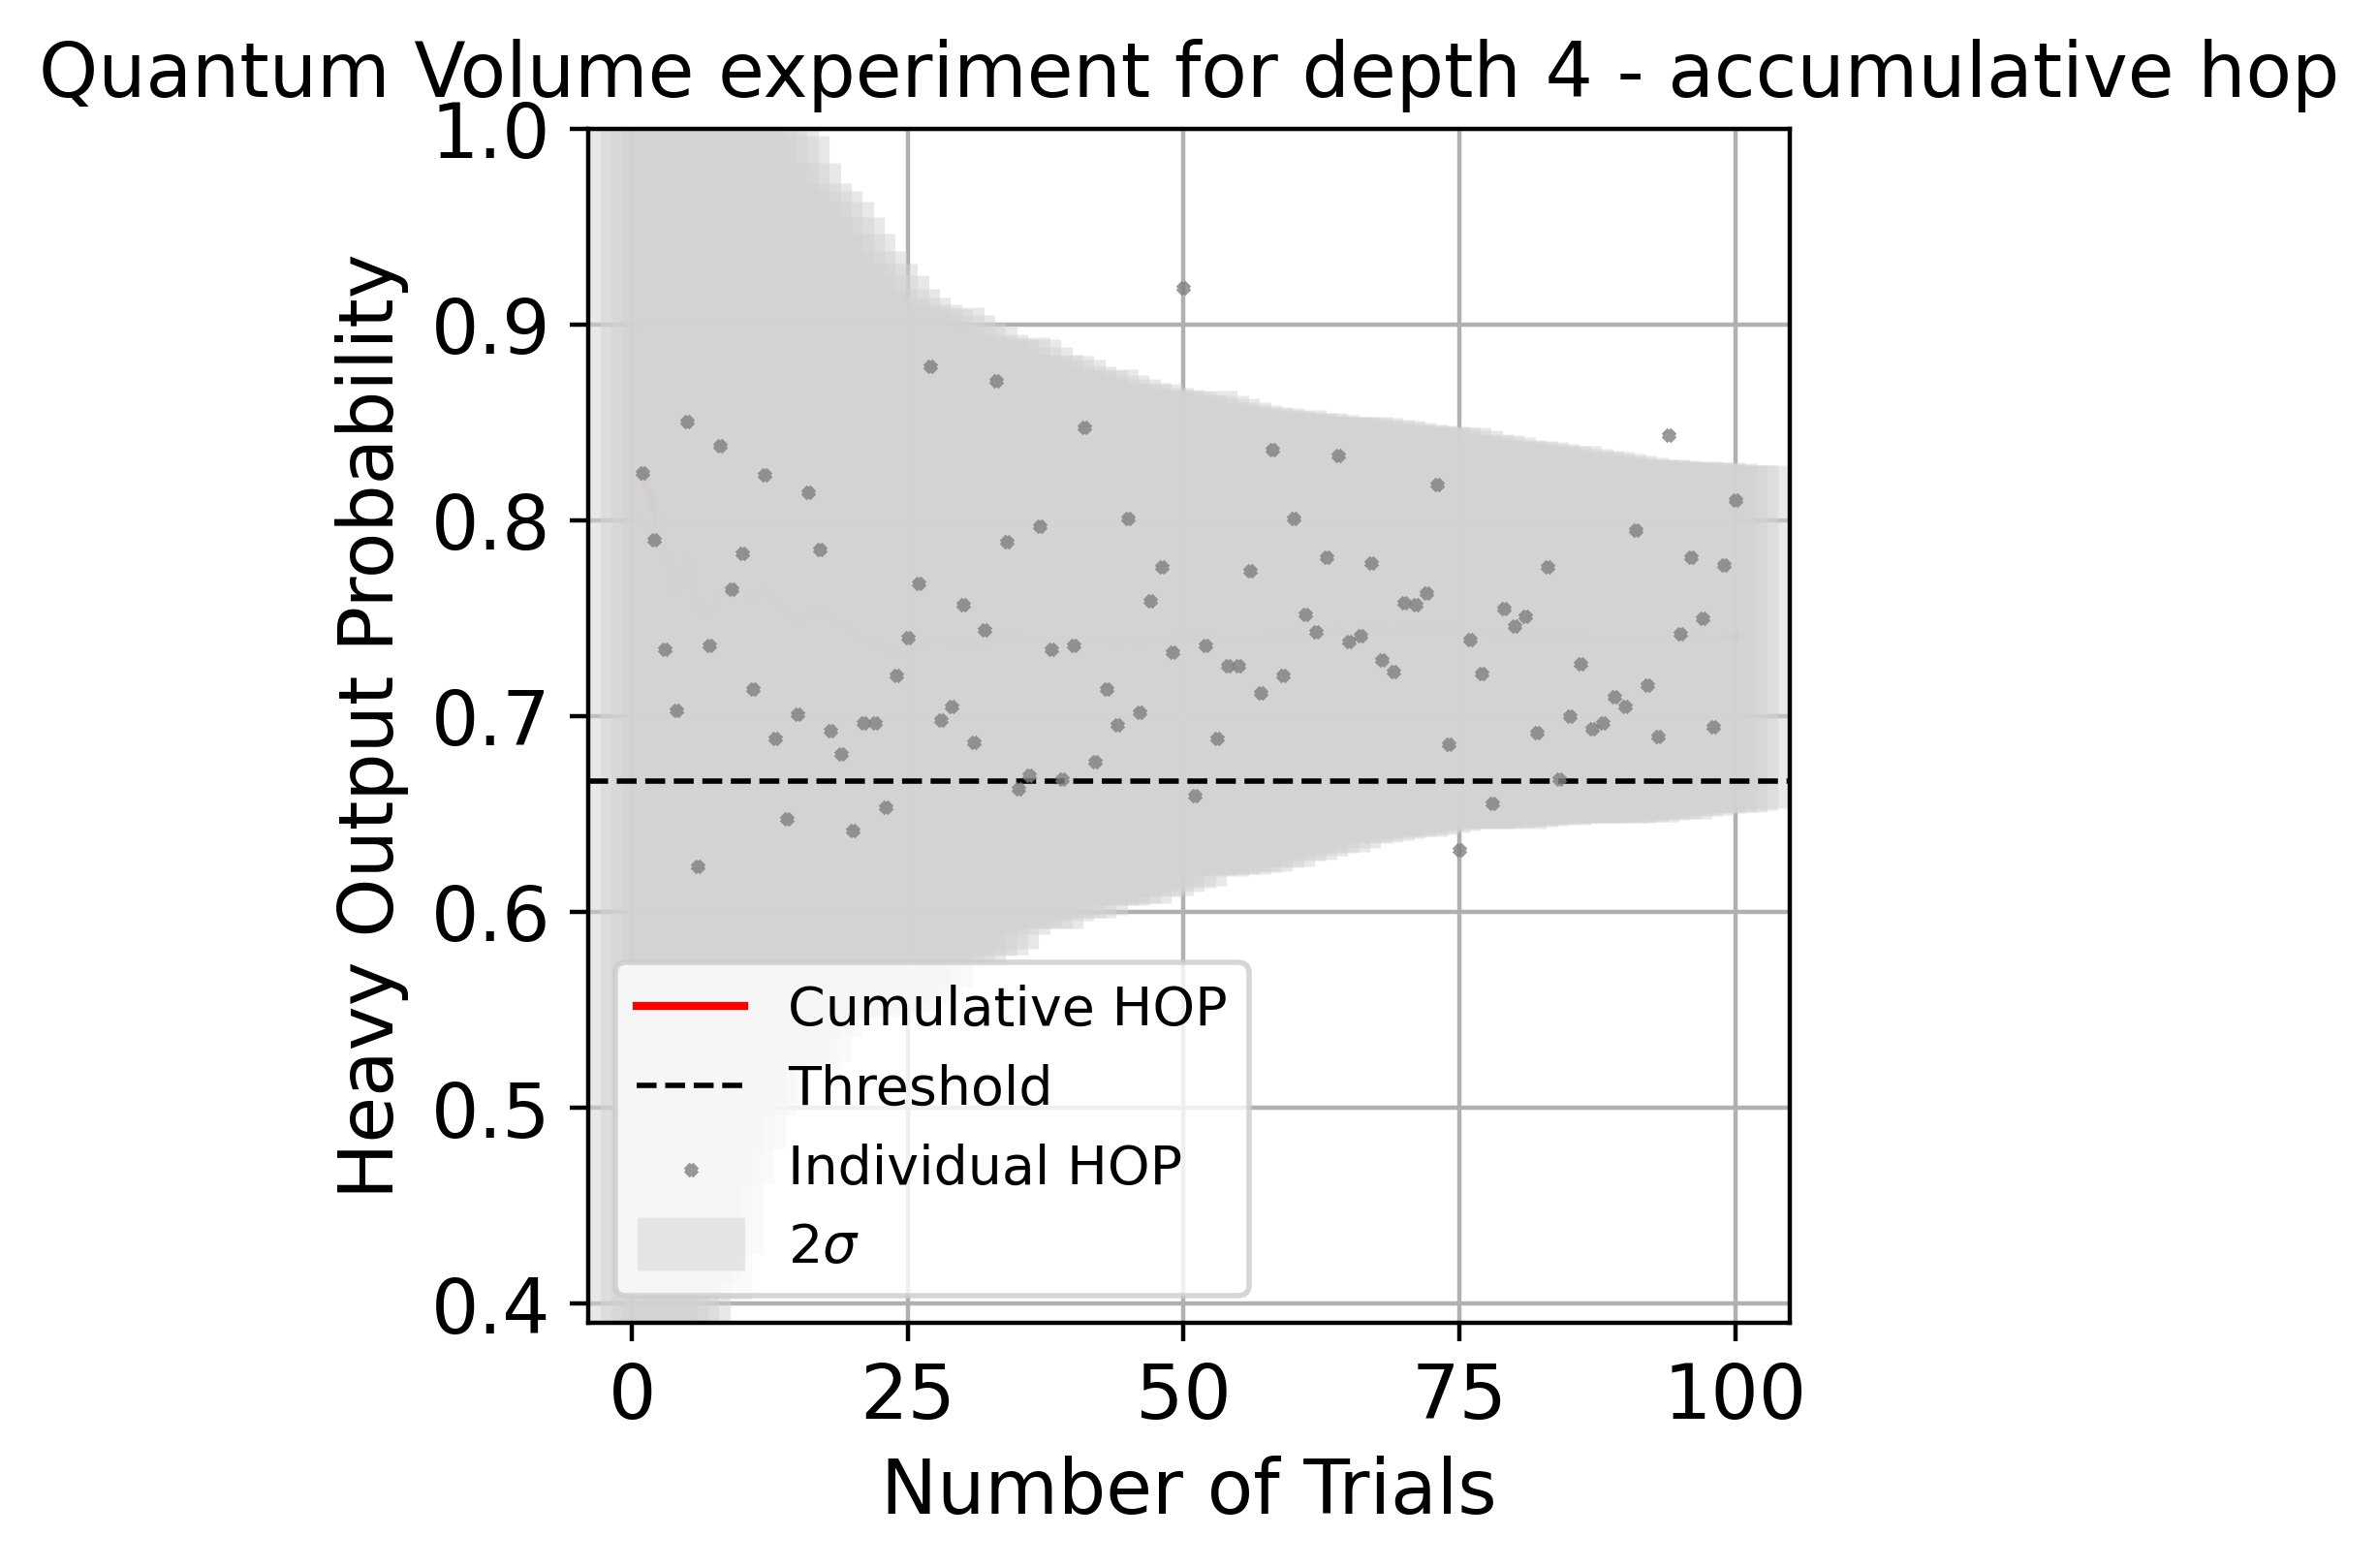

AnalysisResult
- name: mean_HOP
- value: 0.74+/-0.04
- quality: bad
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3']
- verified: False
AnalysisResult
- name: quantum_volume
- value: 1
- quality: bad
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3']
- verified: False


In [87]:
# View result data
display(expdata.figure(0))

for result in expdata.analysis_results():
    print(result)
    

In [88]:
# Print extra data
for result in expdata.analysis_results():
    print(f"\n{result.name} extra:")
    for key, val in result.extra.items():
        print(f"- {key}: {val}")


mean_HOP extra:
- HOPs: [0.82421875, 0.7900390625, 0.734375, 0.703125, 0.8505859375, 0.623046875, 0.736328125, 0.837890625, 0.7646484375, 0.783203125, 0.7138671875, 0.8232421875, 0.6884765625, 0.6474609375, 0.701171875, 0.814453125, 0.78515625, 0.6923828125, 0.6806640625, 0.6416015625, 0.6962890625, 0.6962890625, 0.6533203125, 0.720703125, 0.740234375, 0.767578125, 0.87890625, 0.6982421875, 0.705078125, 0.7568359375, 0.6865234375, 0.744140625, 0.87109375, 0.7890625, 0.6630859375, 0.669921875, 0.796875, 0.734375, 0.66796875, 0.736328125, 0.84765625, 0.6767578125, 0.7138671875, 0.6953125, 0.80078125, 0.7021484375, 0.7587890625, 0.7763671875, 0.732421875, 0.9189453125, 0.6591796875, 0.736328125, 0.6884765625, 0.7255859375, 0.7255859375, 0.7744140625, 0.7119140625, 0.8359375, 0.720703125, 0.80078125, 0.751953125, 0.7431640625, 0.78125, 0.8330078125, 0.73828125, 0.7412109375, 0.7783203125, 0.728515625, 0.72265625, 0.7578125, 0.7568359375, 0.7626953125, 0.818359375, 0.685546875, 0.631835937

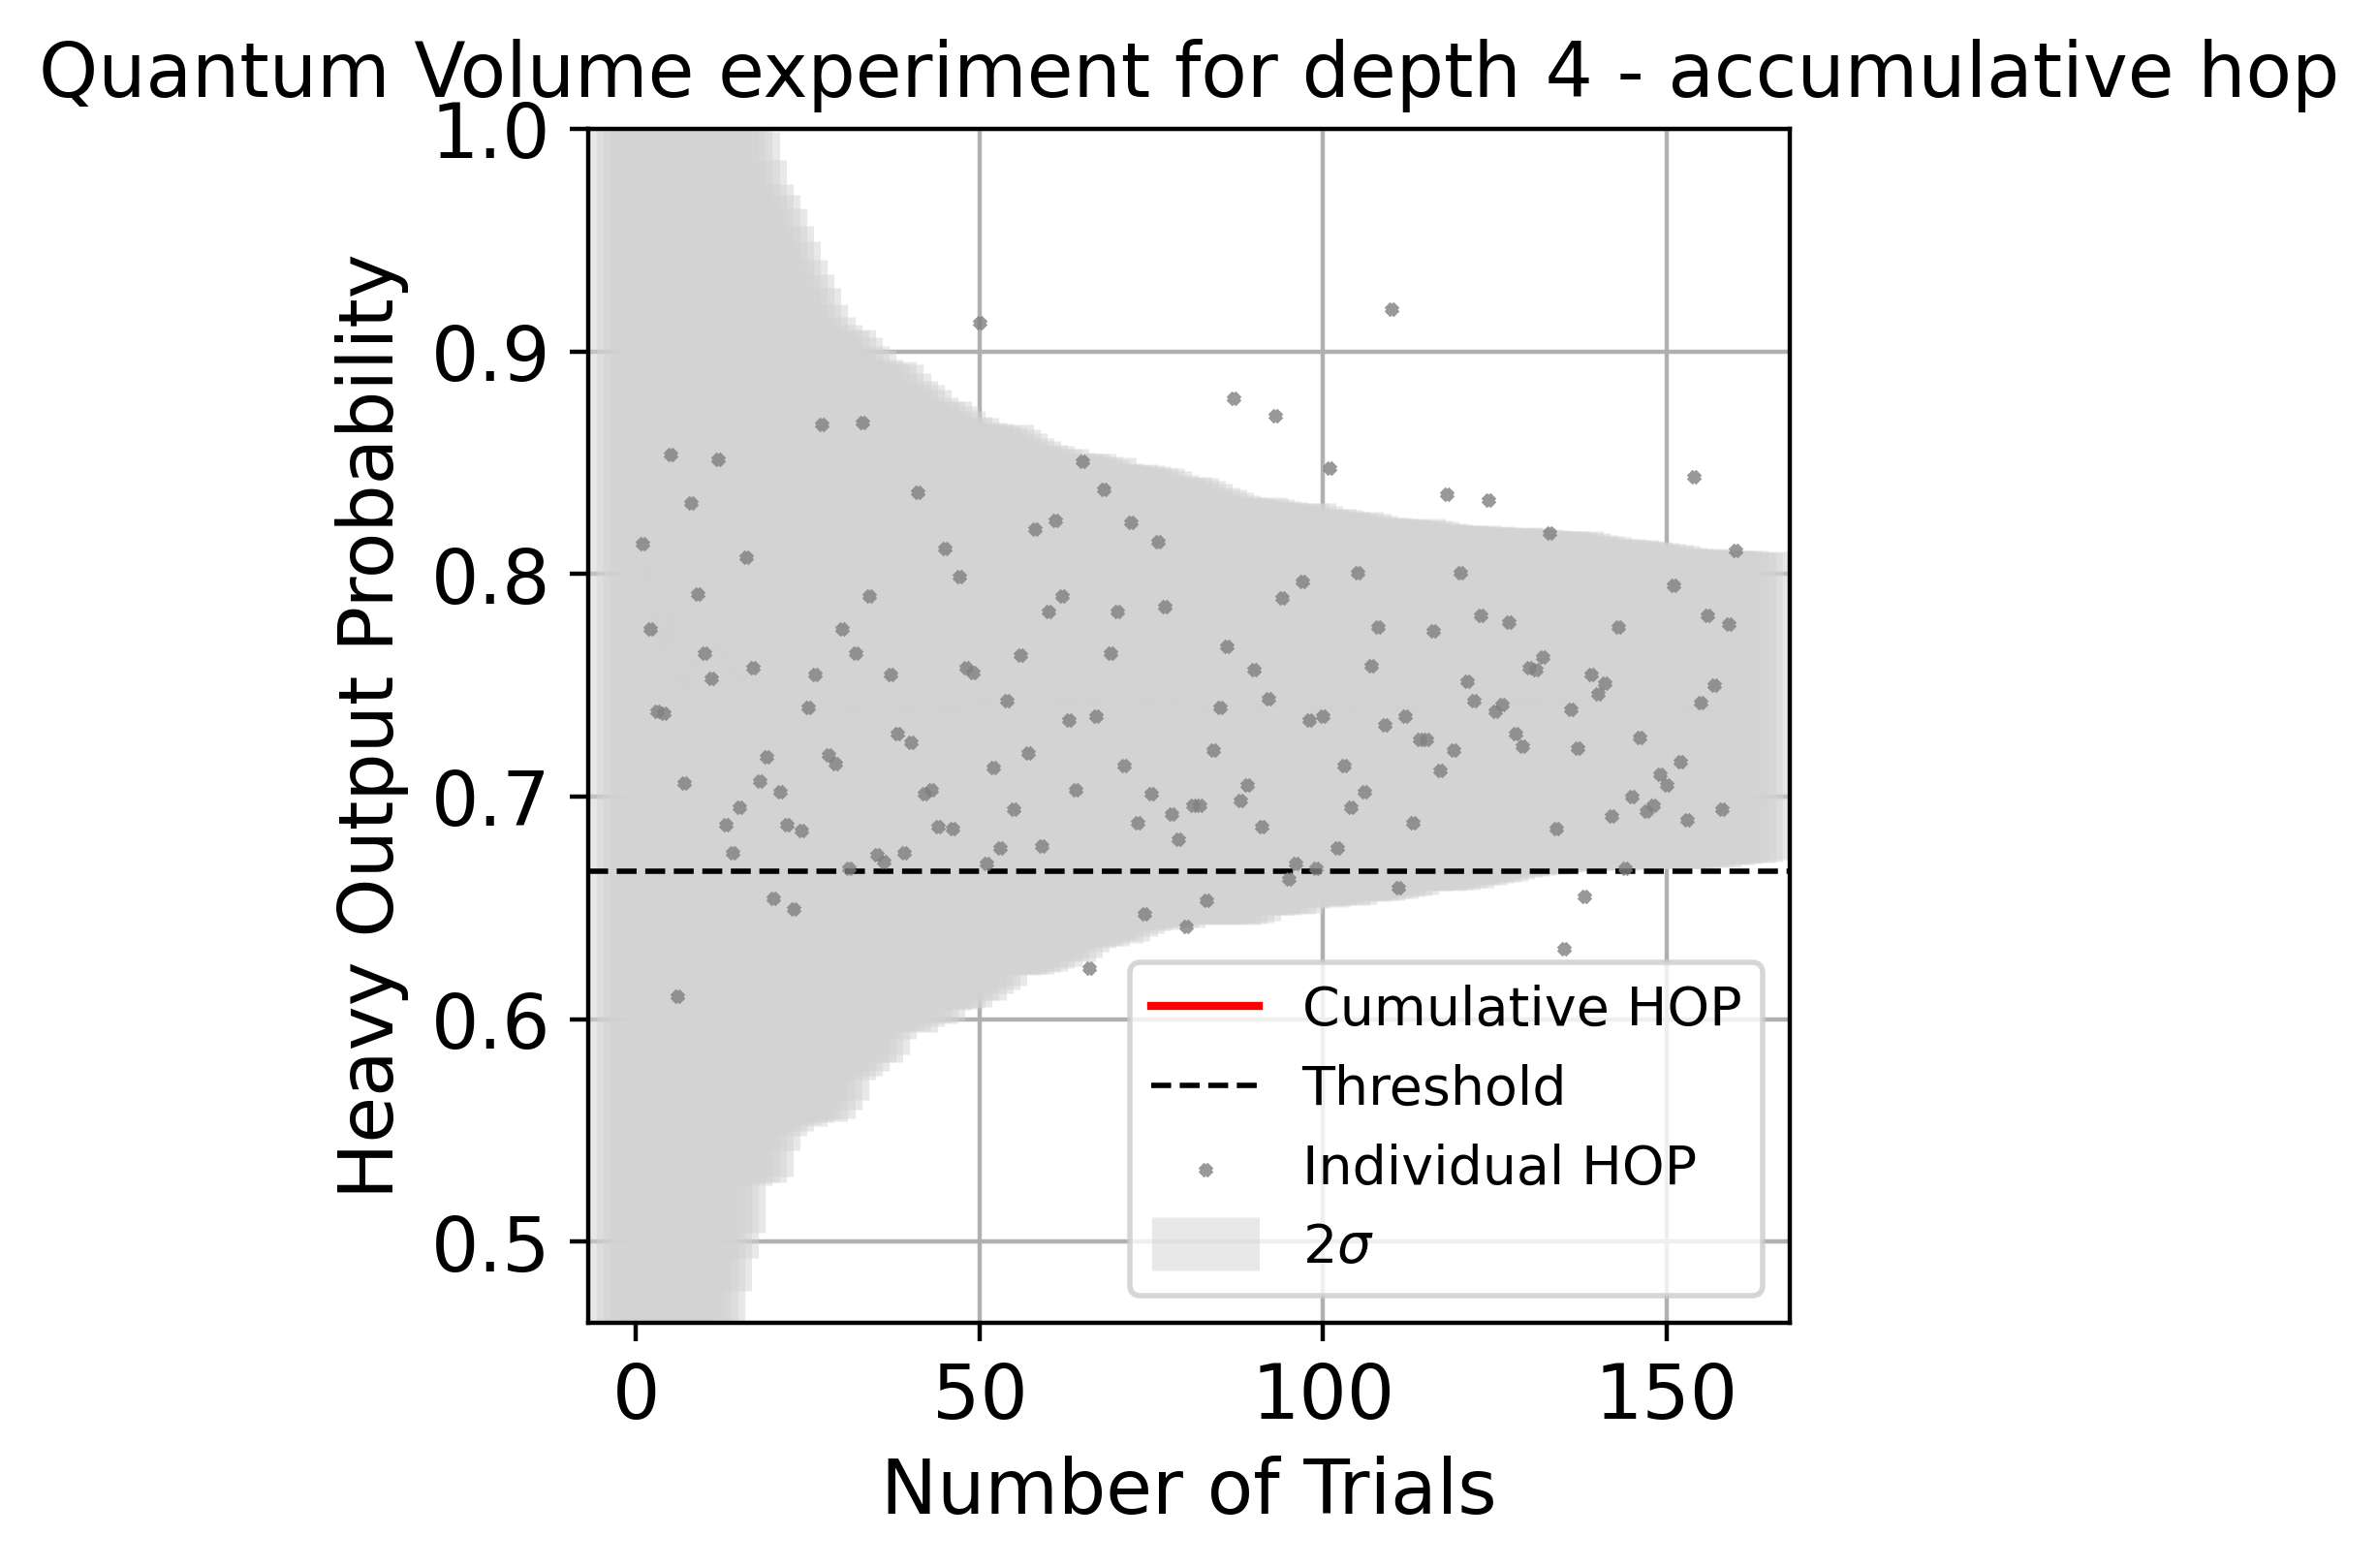

AnalysisResult
- name: mean_HOP
- value: 0.741+/-0.035
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3']
- verified: False
AnalysisResult
- name: quantum_volume
- value: 16
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3']
- verified: False


In [89]:
qv_exp.set_experiment_options(trials=60)
expdata2 = qv_exp.run(backend, analysis=None).block_for_results()
expdata2.add_data(expdata.data())
qv_exp.analysis.run(expdata2).block_for_results()

# View result data
display(expdata2.figure(0))
for result in expdata2.analysis_results():
    print(result)

In [90]:
exps = [QuantumVolume(tuple(range(i)), trials=200) for i in range(3, 6)]

batch_exp = BatchExperiment(exps)
batch_exp.set_transpile_options(optimization_level=3)

# Run
batch_expdata = batch_exp.run(backend).block_for_results()

In [91]:
qv_values = [
    batch_expdata.child_data(i).analysis_results("quantum_volume").value
    for i in range(batch_exp.num_experiments)
]

print(f"Max quantum volume is: {max(qv_values)}")

Max quantum volume is: 16



Component experiment 0


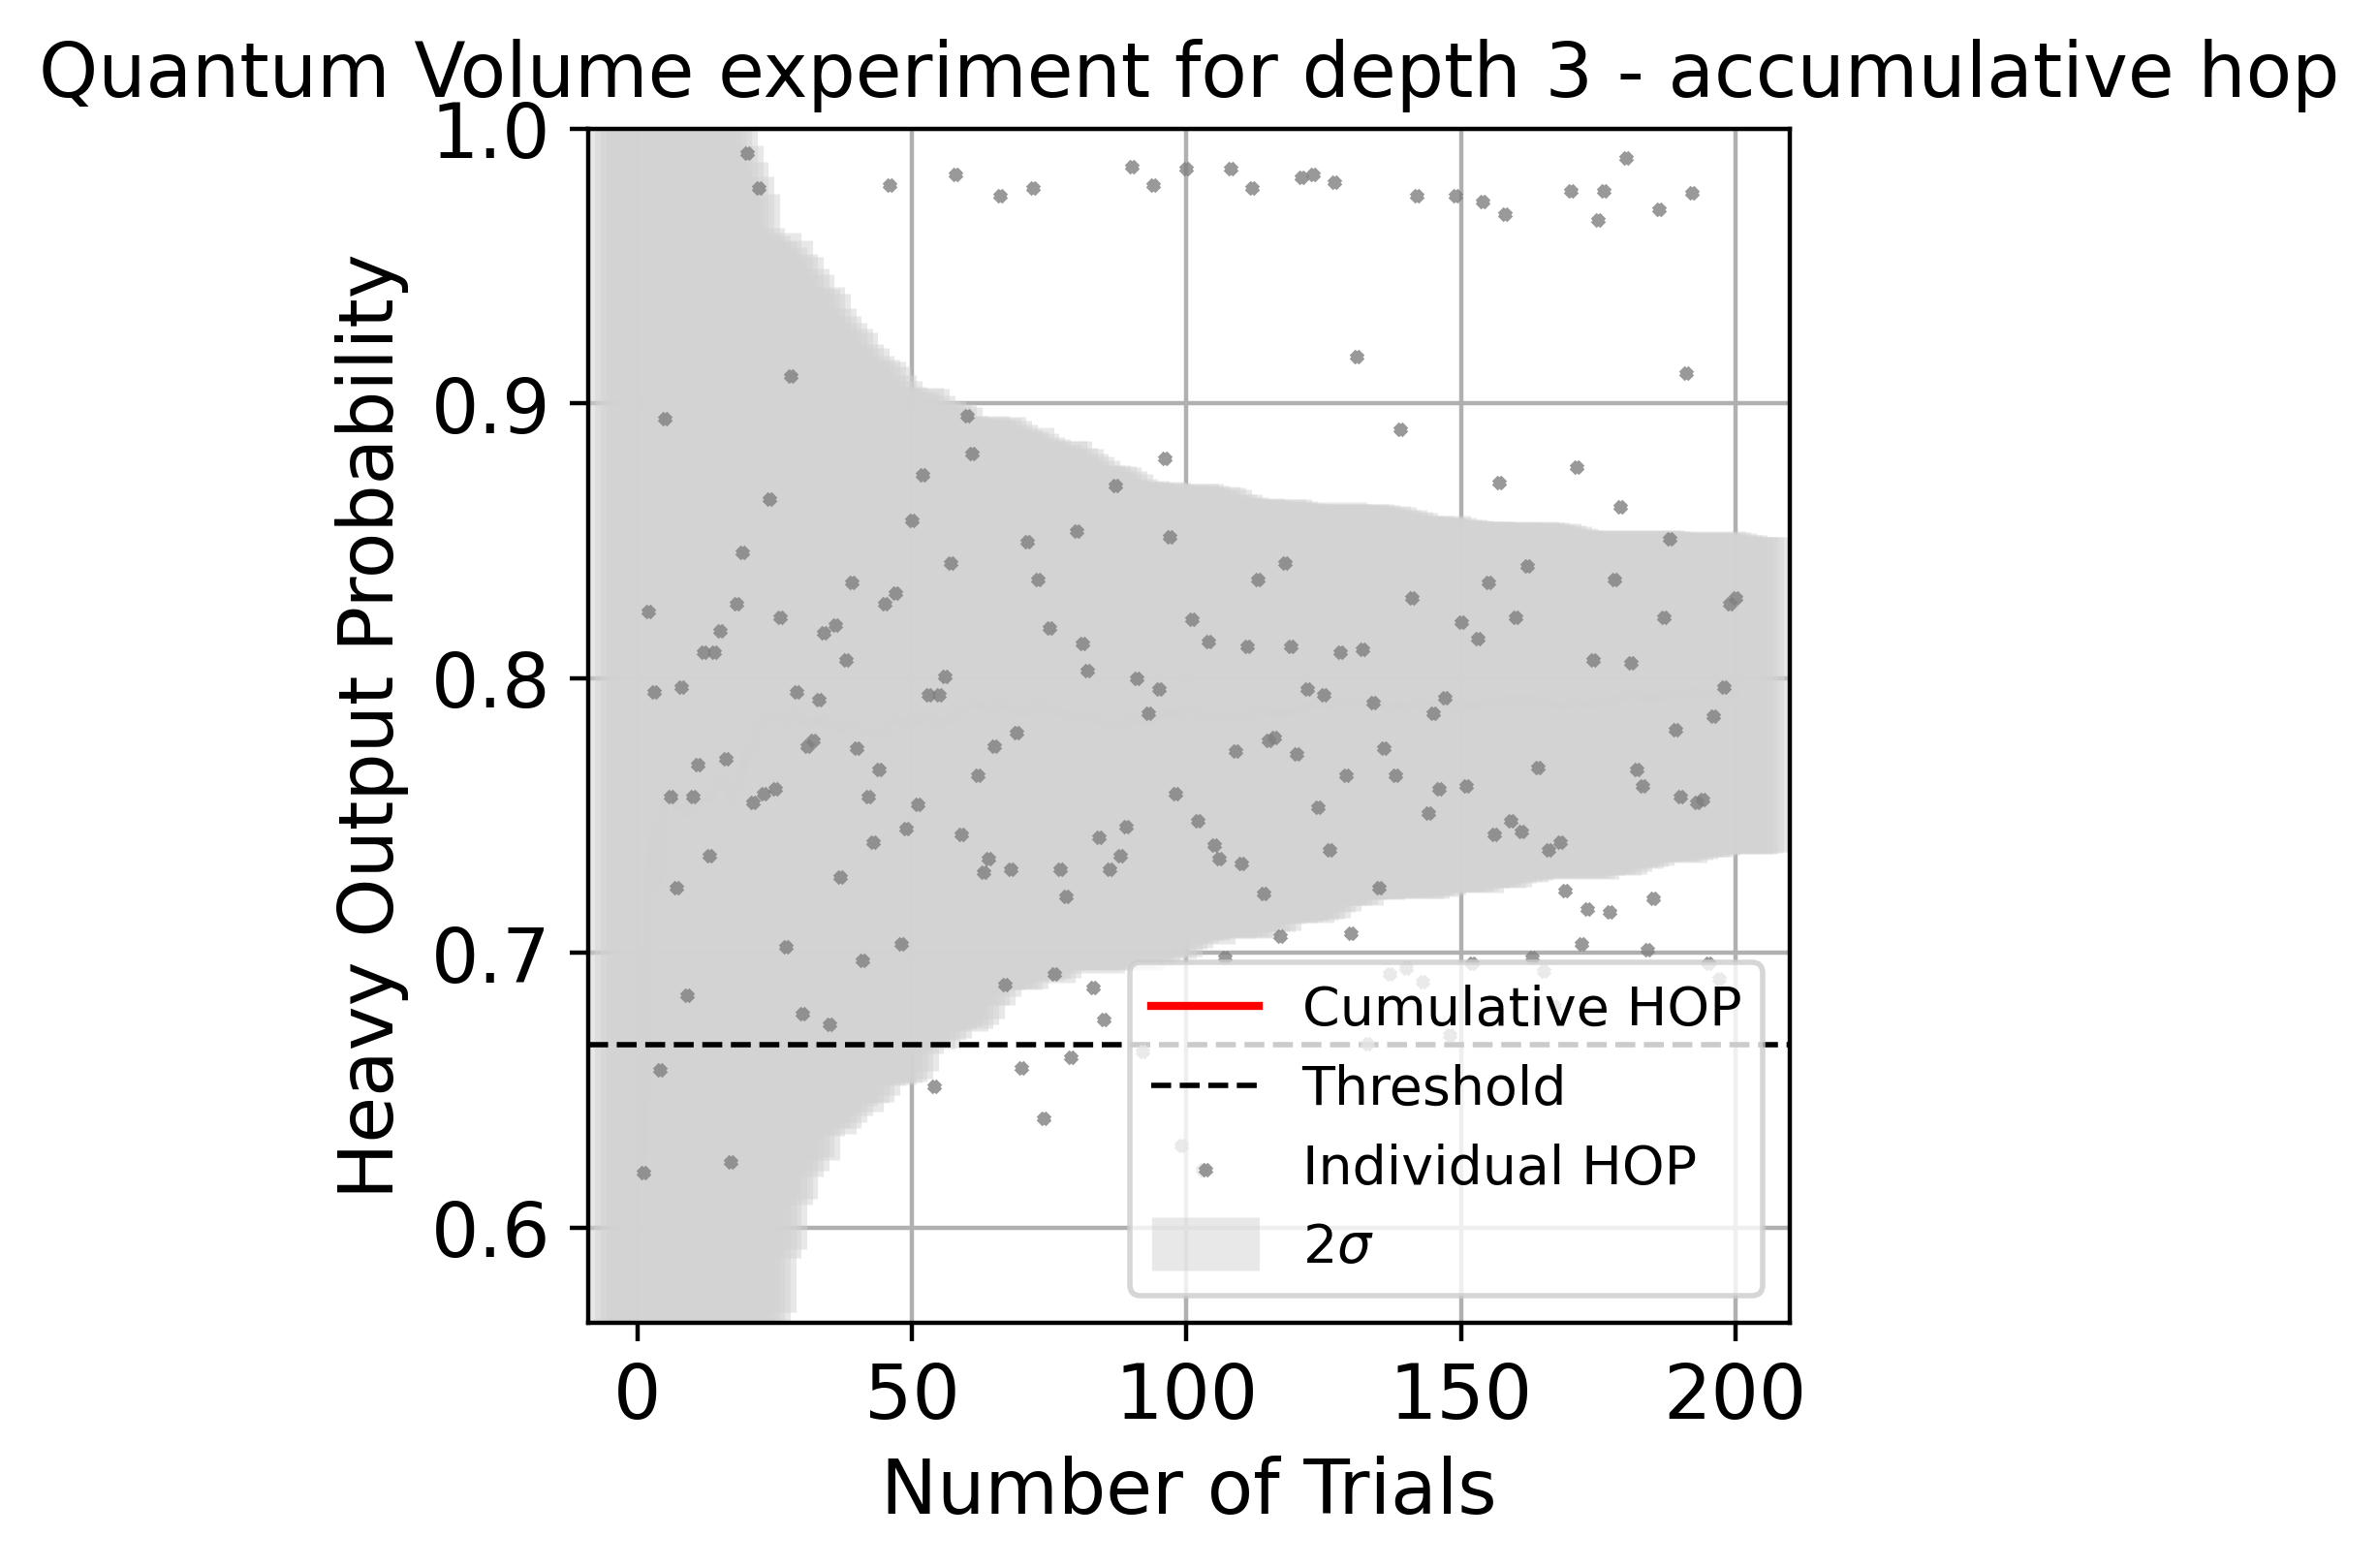

AnalysisResult
- name: mean_HOP
- value: 0.794+/-0.029
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2']
- verified: False
AnalysisResult
- name: quantum_volume
- value: 8
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2']
- verified: False

Component experiment 1


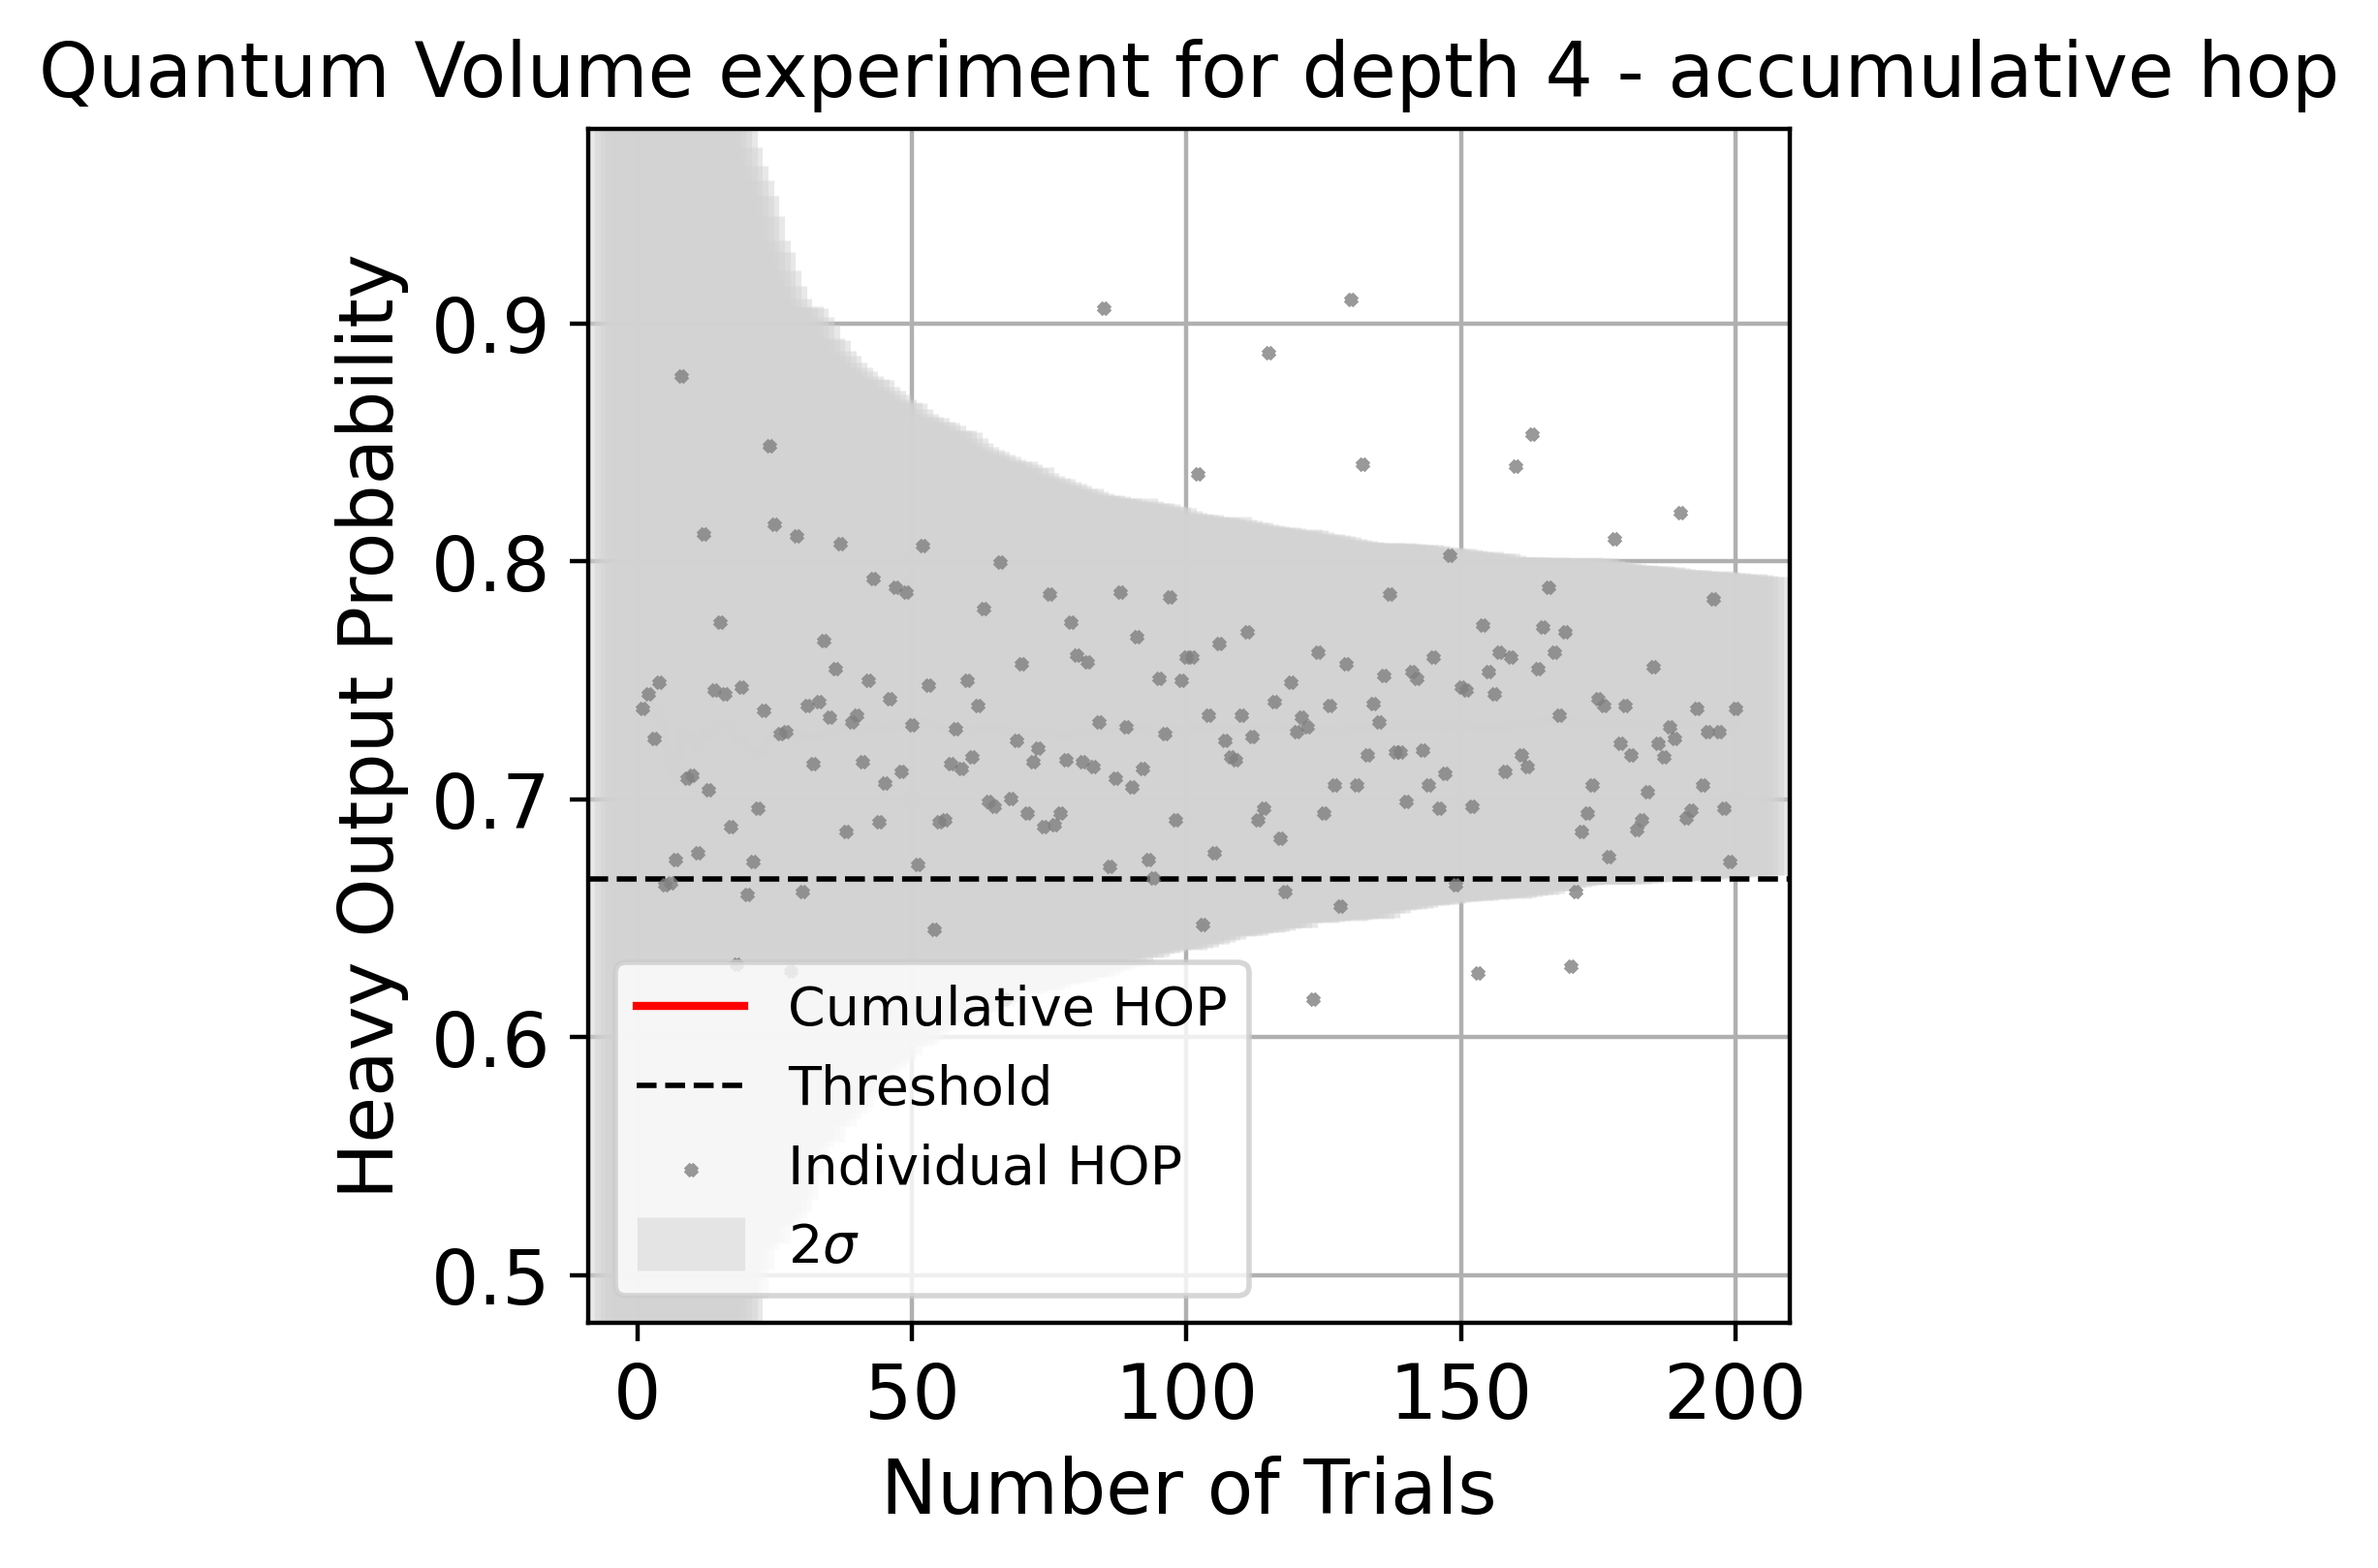

AnalysisResult
- name: mean_HOP
- value: 0.731+/-0.031
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3']
- verified: False
AnalysisResult
- name: quantum_volume
- value: 16
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3']
- verified: False

Component experiment 2


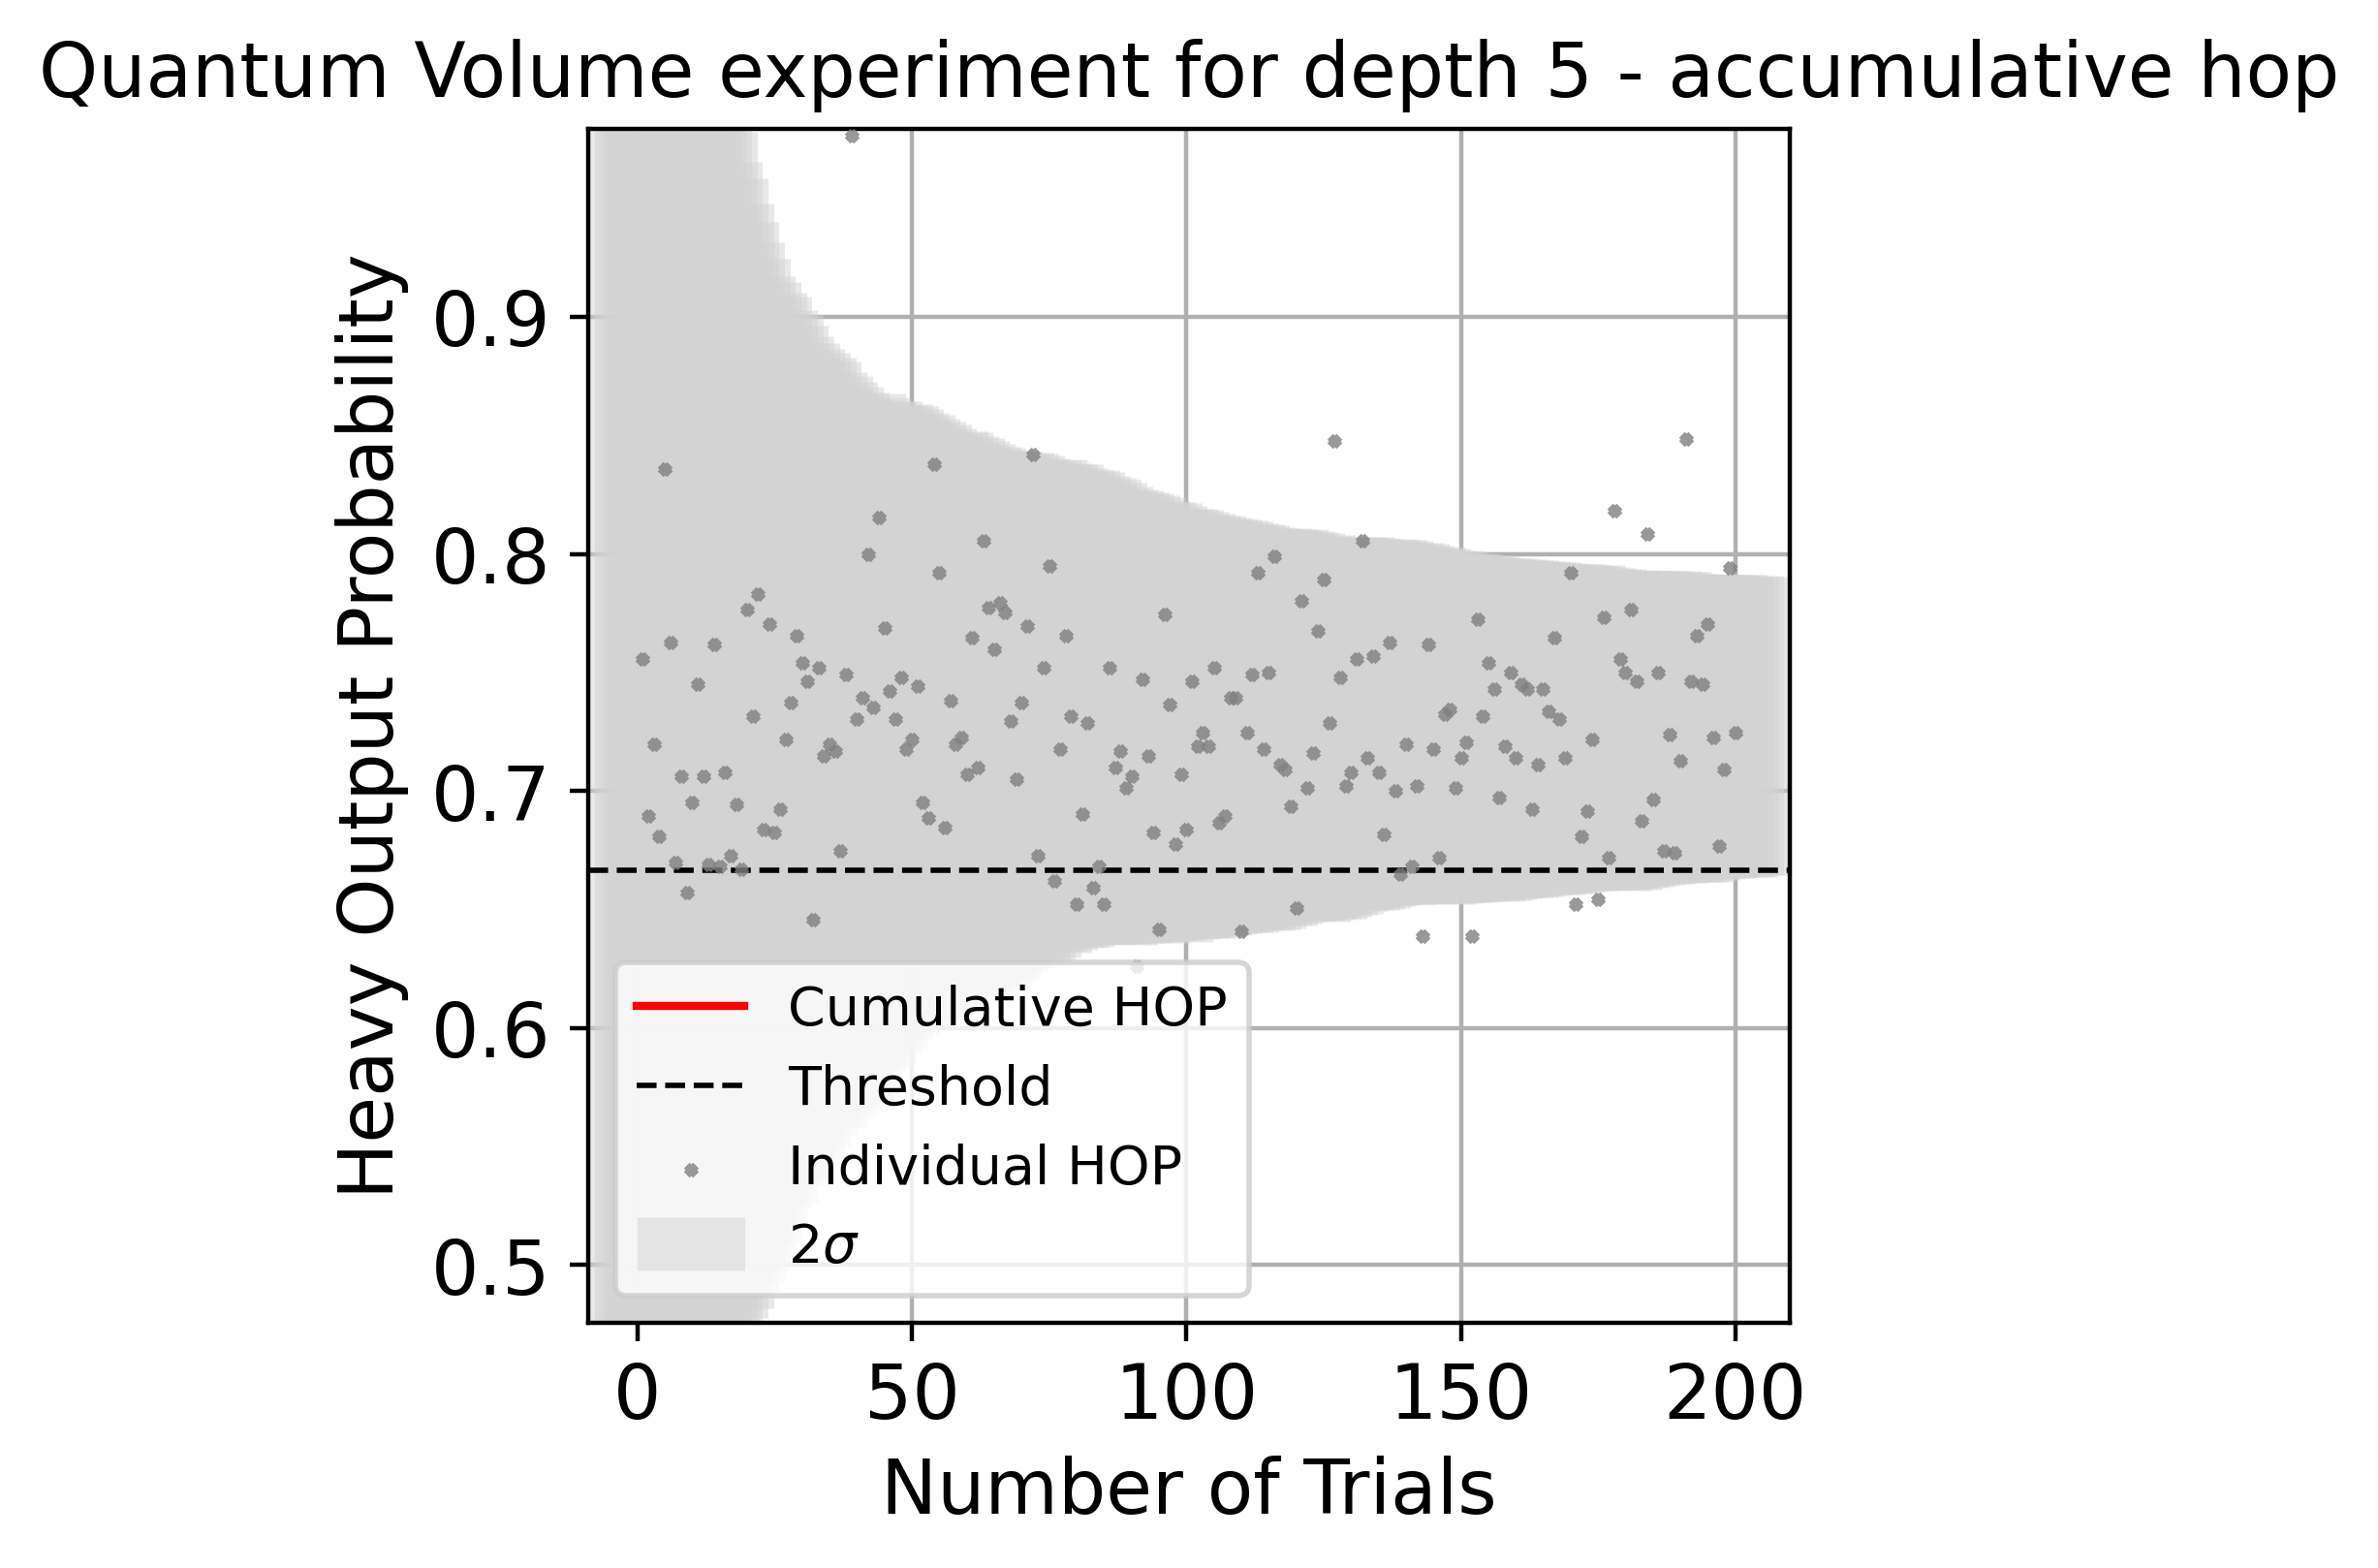

AnalysisResult
- name: mean_HOP
- value: 0.728+/-0.031
- quality: bad
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
- verified: False
AnalysisResult
- name: quantum_volume
- value: 1
- quality: bad
- extra: <4 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
- verified: False


In [92]:
for i in range(batch_exp.num_experiments):
    print(f"\nComponent experiment {i}")
    sub_data = batch_expdata.child_data(i)
    display(sub_data.figure(0))
    for result in sub_data.analysis_results():
        print(result)

In [93]:
import numpy as np

from qiskit import pulse
from qiskit.circuit import Parameter

from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend
from qiskit_experiments.data_processing import DataProcessor, nodes
from qiskit_experiments.library import Rabi

with pulse.build() as sched:
    pulse.play(
        pulse.Gaussian(160, Parameter("amp"), sigma=40),
        pulse.DriveChannel(0)
    )

backend = SingleTransmonTestBackend(seed=100)

exp = Rabi(
    qubit=0,
    backend=backend,
    schedule=sched,
    amplitudes=np.linspace(-0.1, 0.1, 21)
)

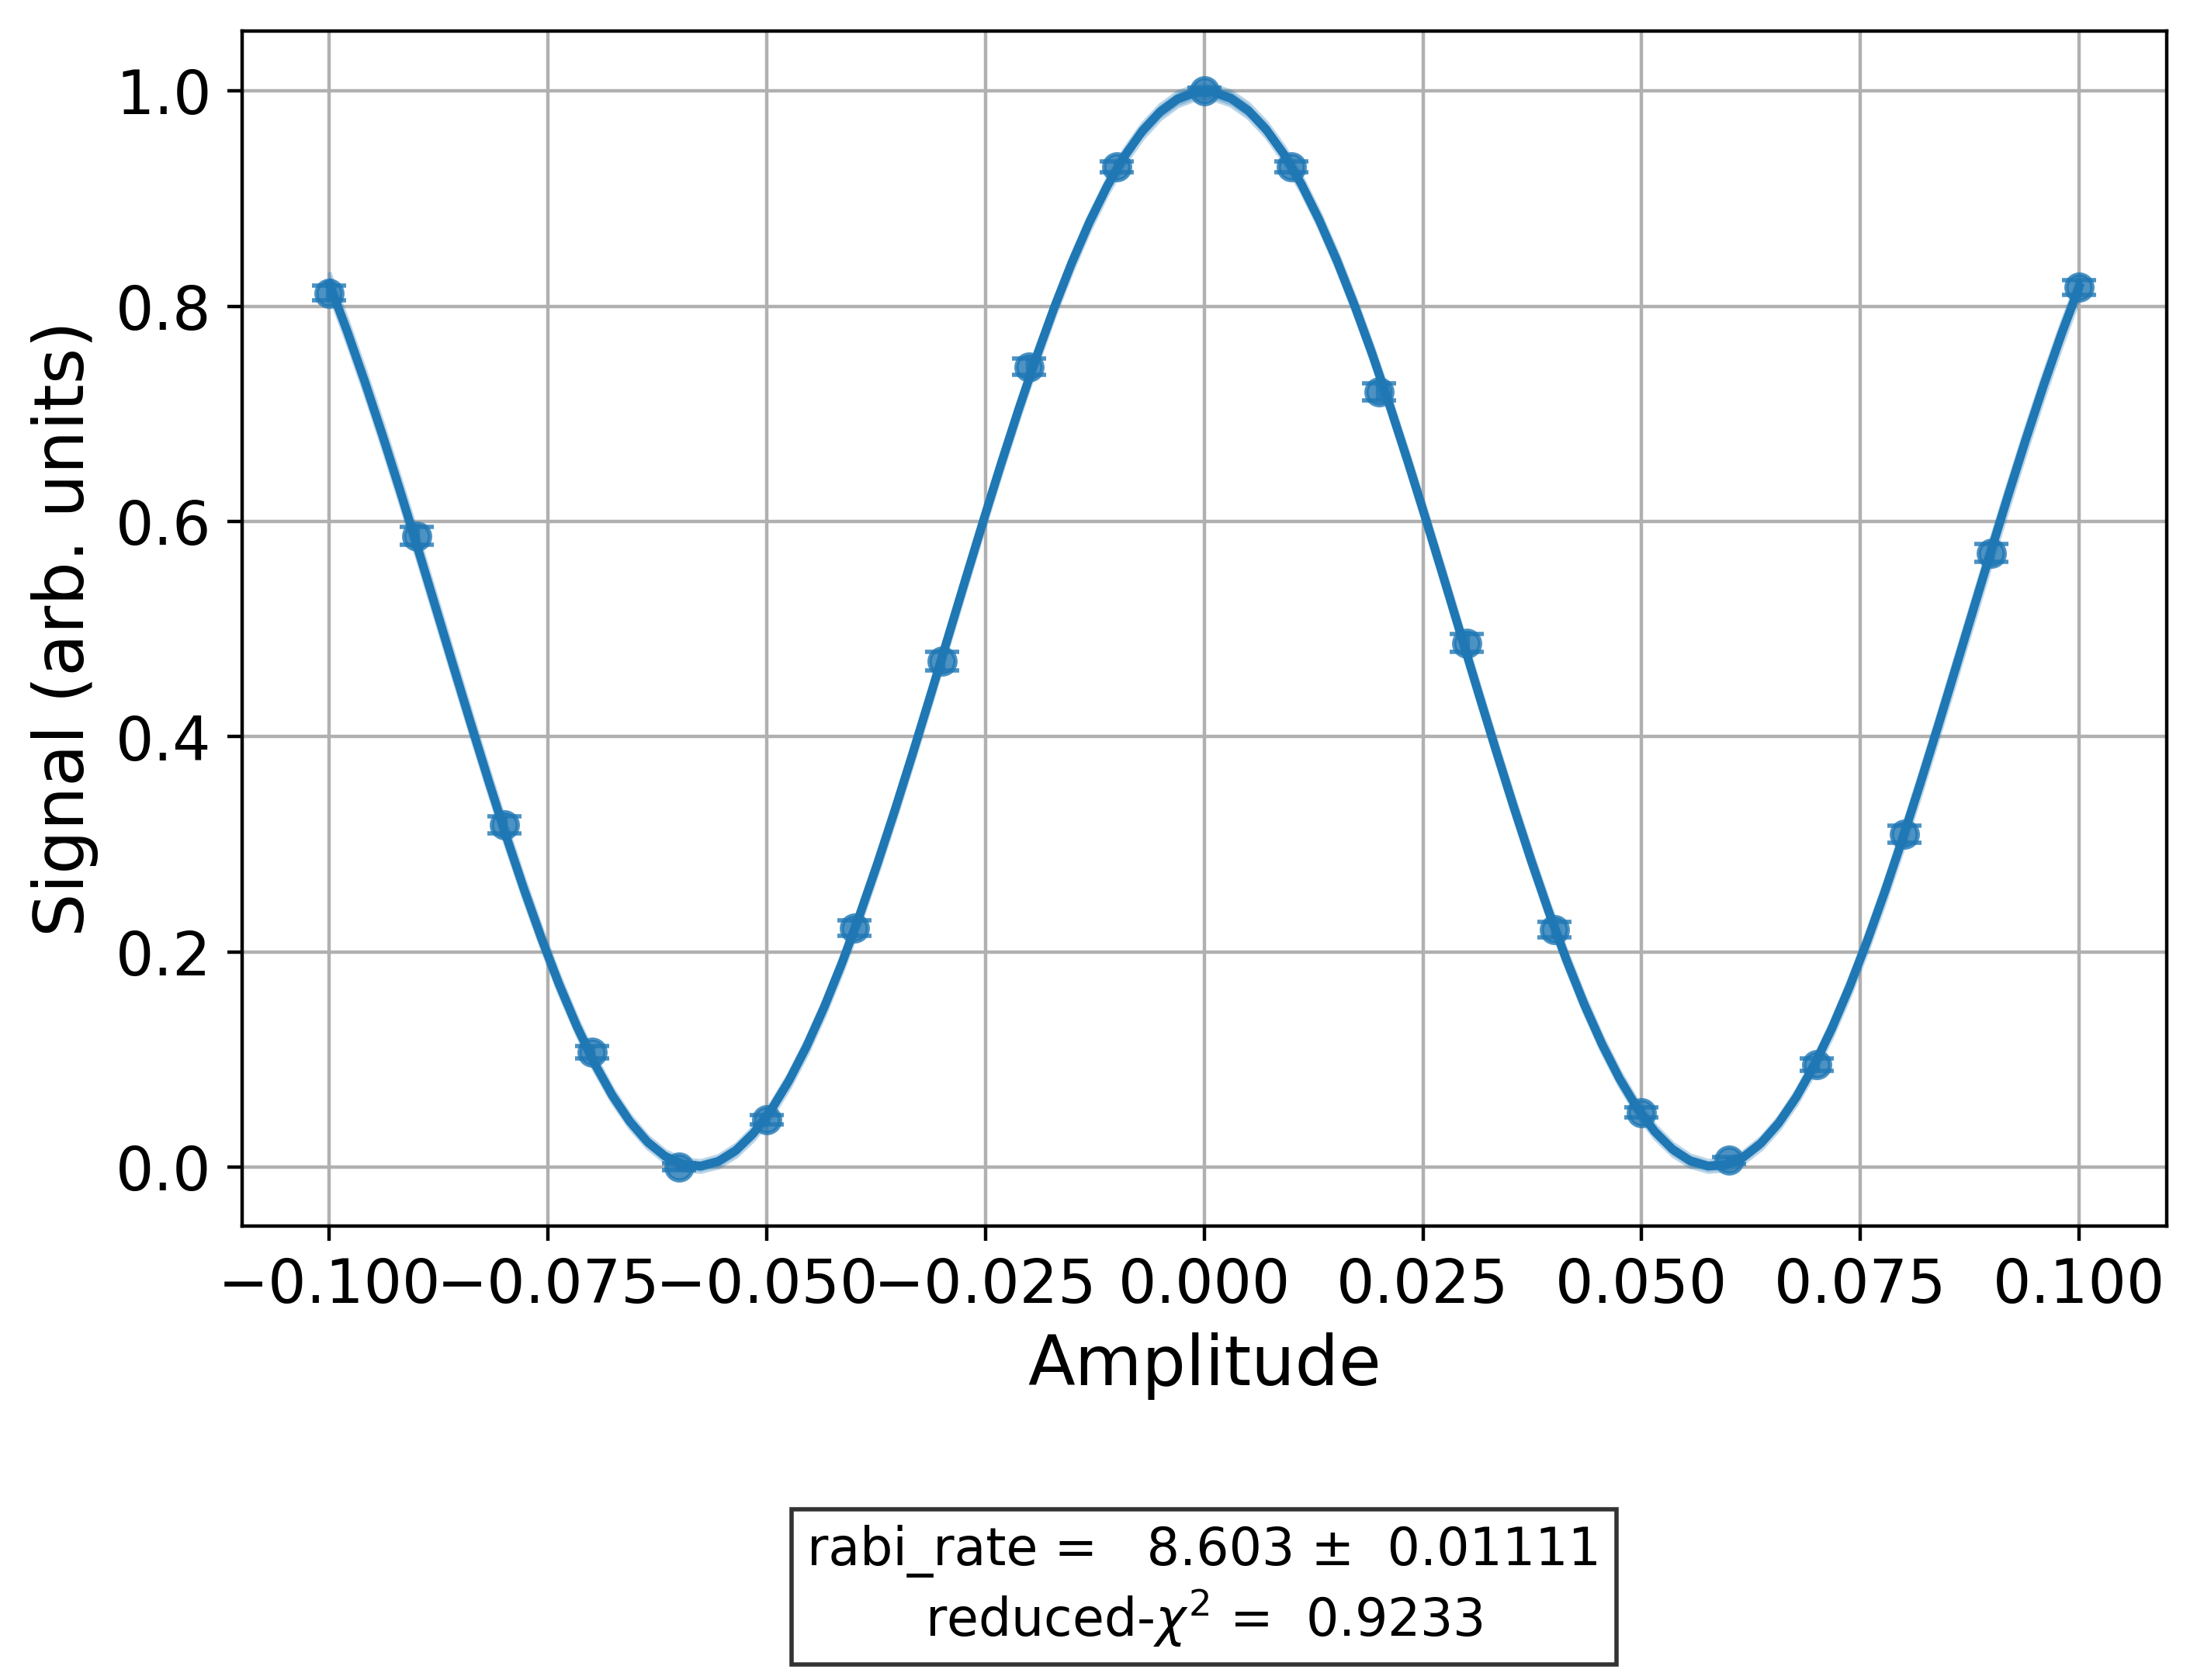

In [94]:
data_nodes = [nodes.SVD(), nodes.AverageData(axis=1), nodes.MinMaxNormalize()]
iq_processor = DataProcessor("memory", data_nodes)
exp.analysis.set_options(data_processor=iq_processor)

exp_data = exp.run(meas_level=1, meas_return="single").block_for_results()

display(exp_data.figure(0))

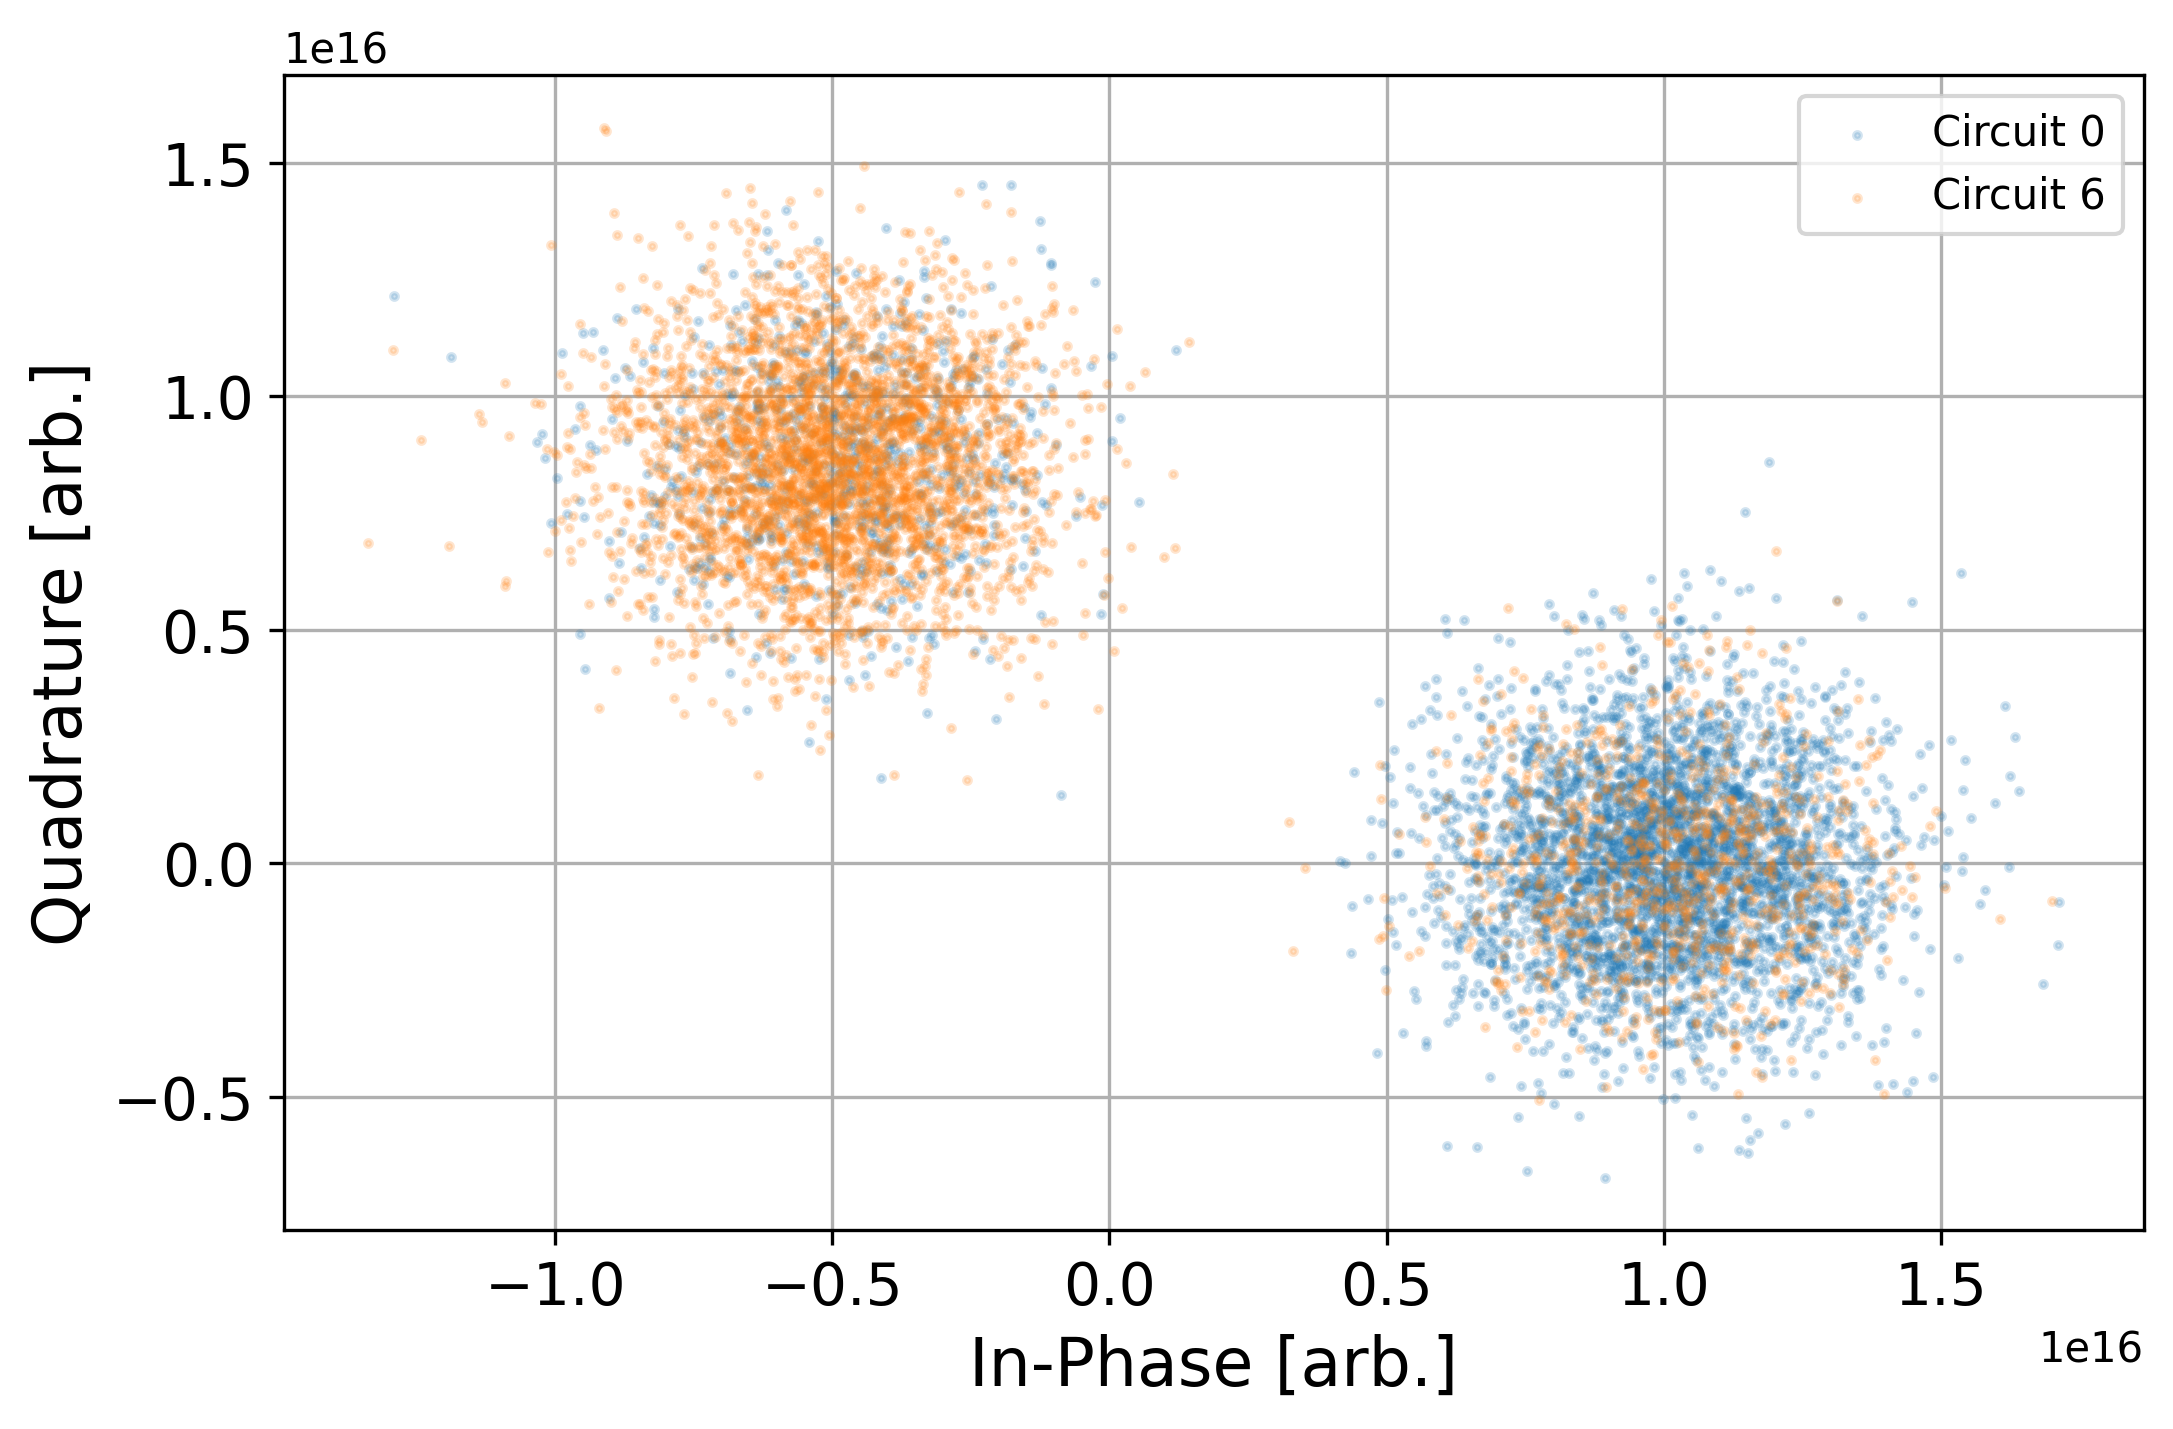

In [95]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams['figure.dpi'] = 300

# Your existing code here...
from qiskit_experiments.visualization import IQPlotter, MplDrawer

plotter = IQPlotter(MplDrawer())

for idx in [0, 6]:
    plotter.set_series_data(
        f"Circuit {idx}",
        points=np.array(exp_data.data(idx)["memory"]).squeeze(),
    )

plotter.figure()

/opt/conda/lib/python3.10/site-packages/qiskit_experiments/visualization/plotters/base_plotter.py:259: UserWarning: IQPlotter encountered an unknown data key color. It may not be used by the plotter class.
  warnings.warn(


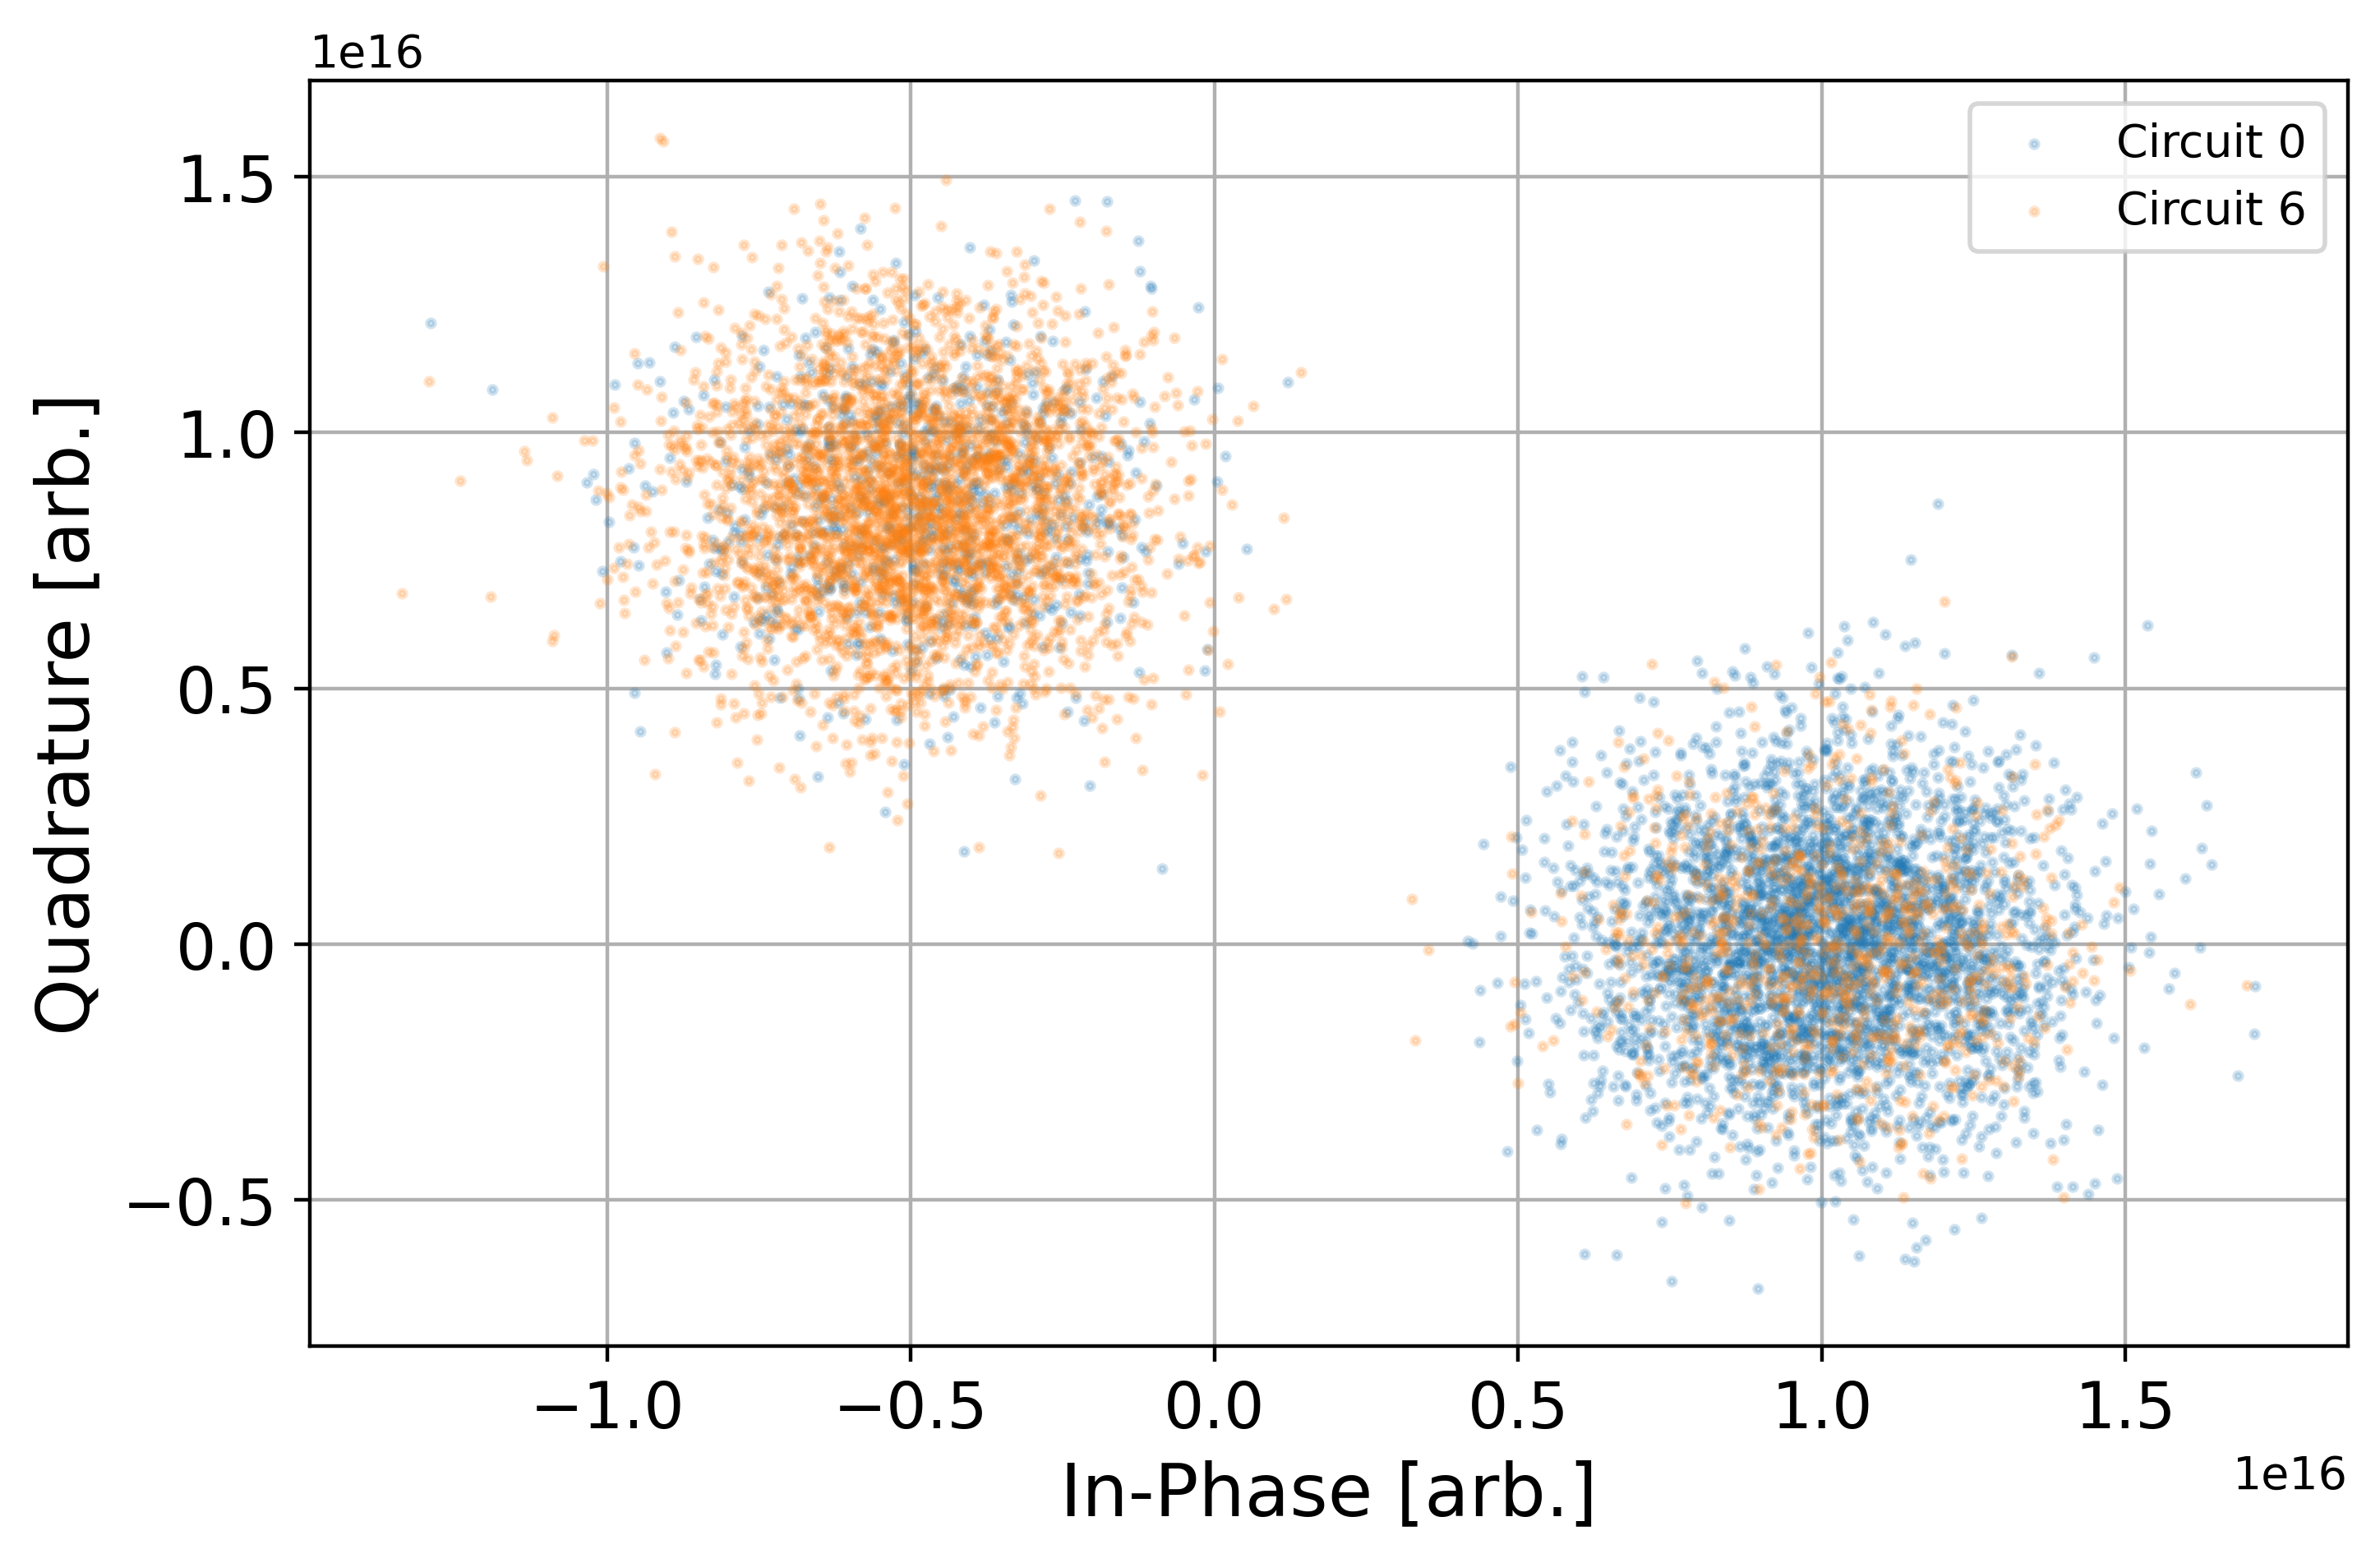

In [96]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams['figure.dpi'] = 400

for idx, color in zip([0, 6], ['red', 'blue']):
    plotter.set_series_data(
        f"Circuit {idx}",
        points=np.array(exp_data.data(idx)["memory"]).squeeze(),
        color=color
    )

# Your existing code here...
from qiskit_experiments.visualization import IQPlotter, MplDrawer

plotter = IQPlotter(MplDrawer())

for idx in [0, 6]:
    plotter.set_series_data(
        f"Circuit {idx}",
        points=np.array(exp_data.data(idx)["memory"]).squeeze(),
    )

plotter.figure()

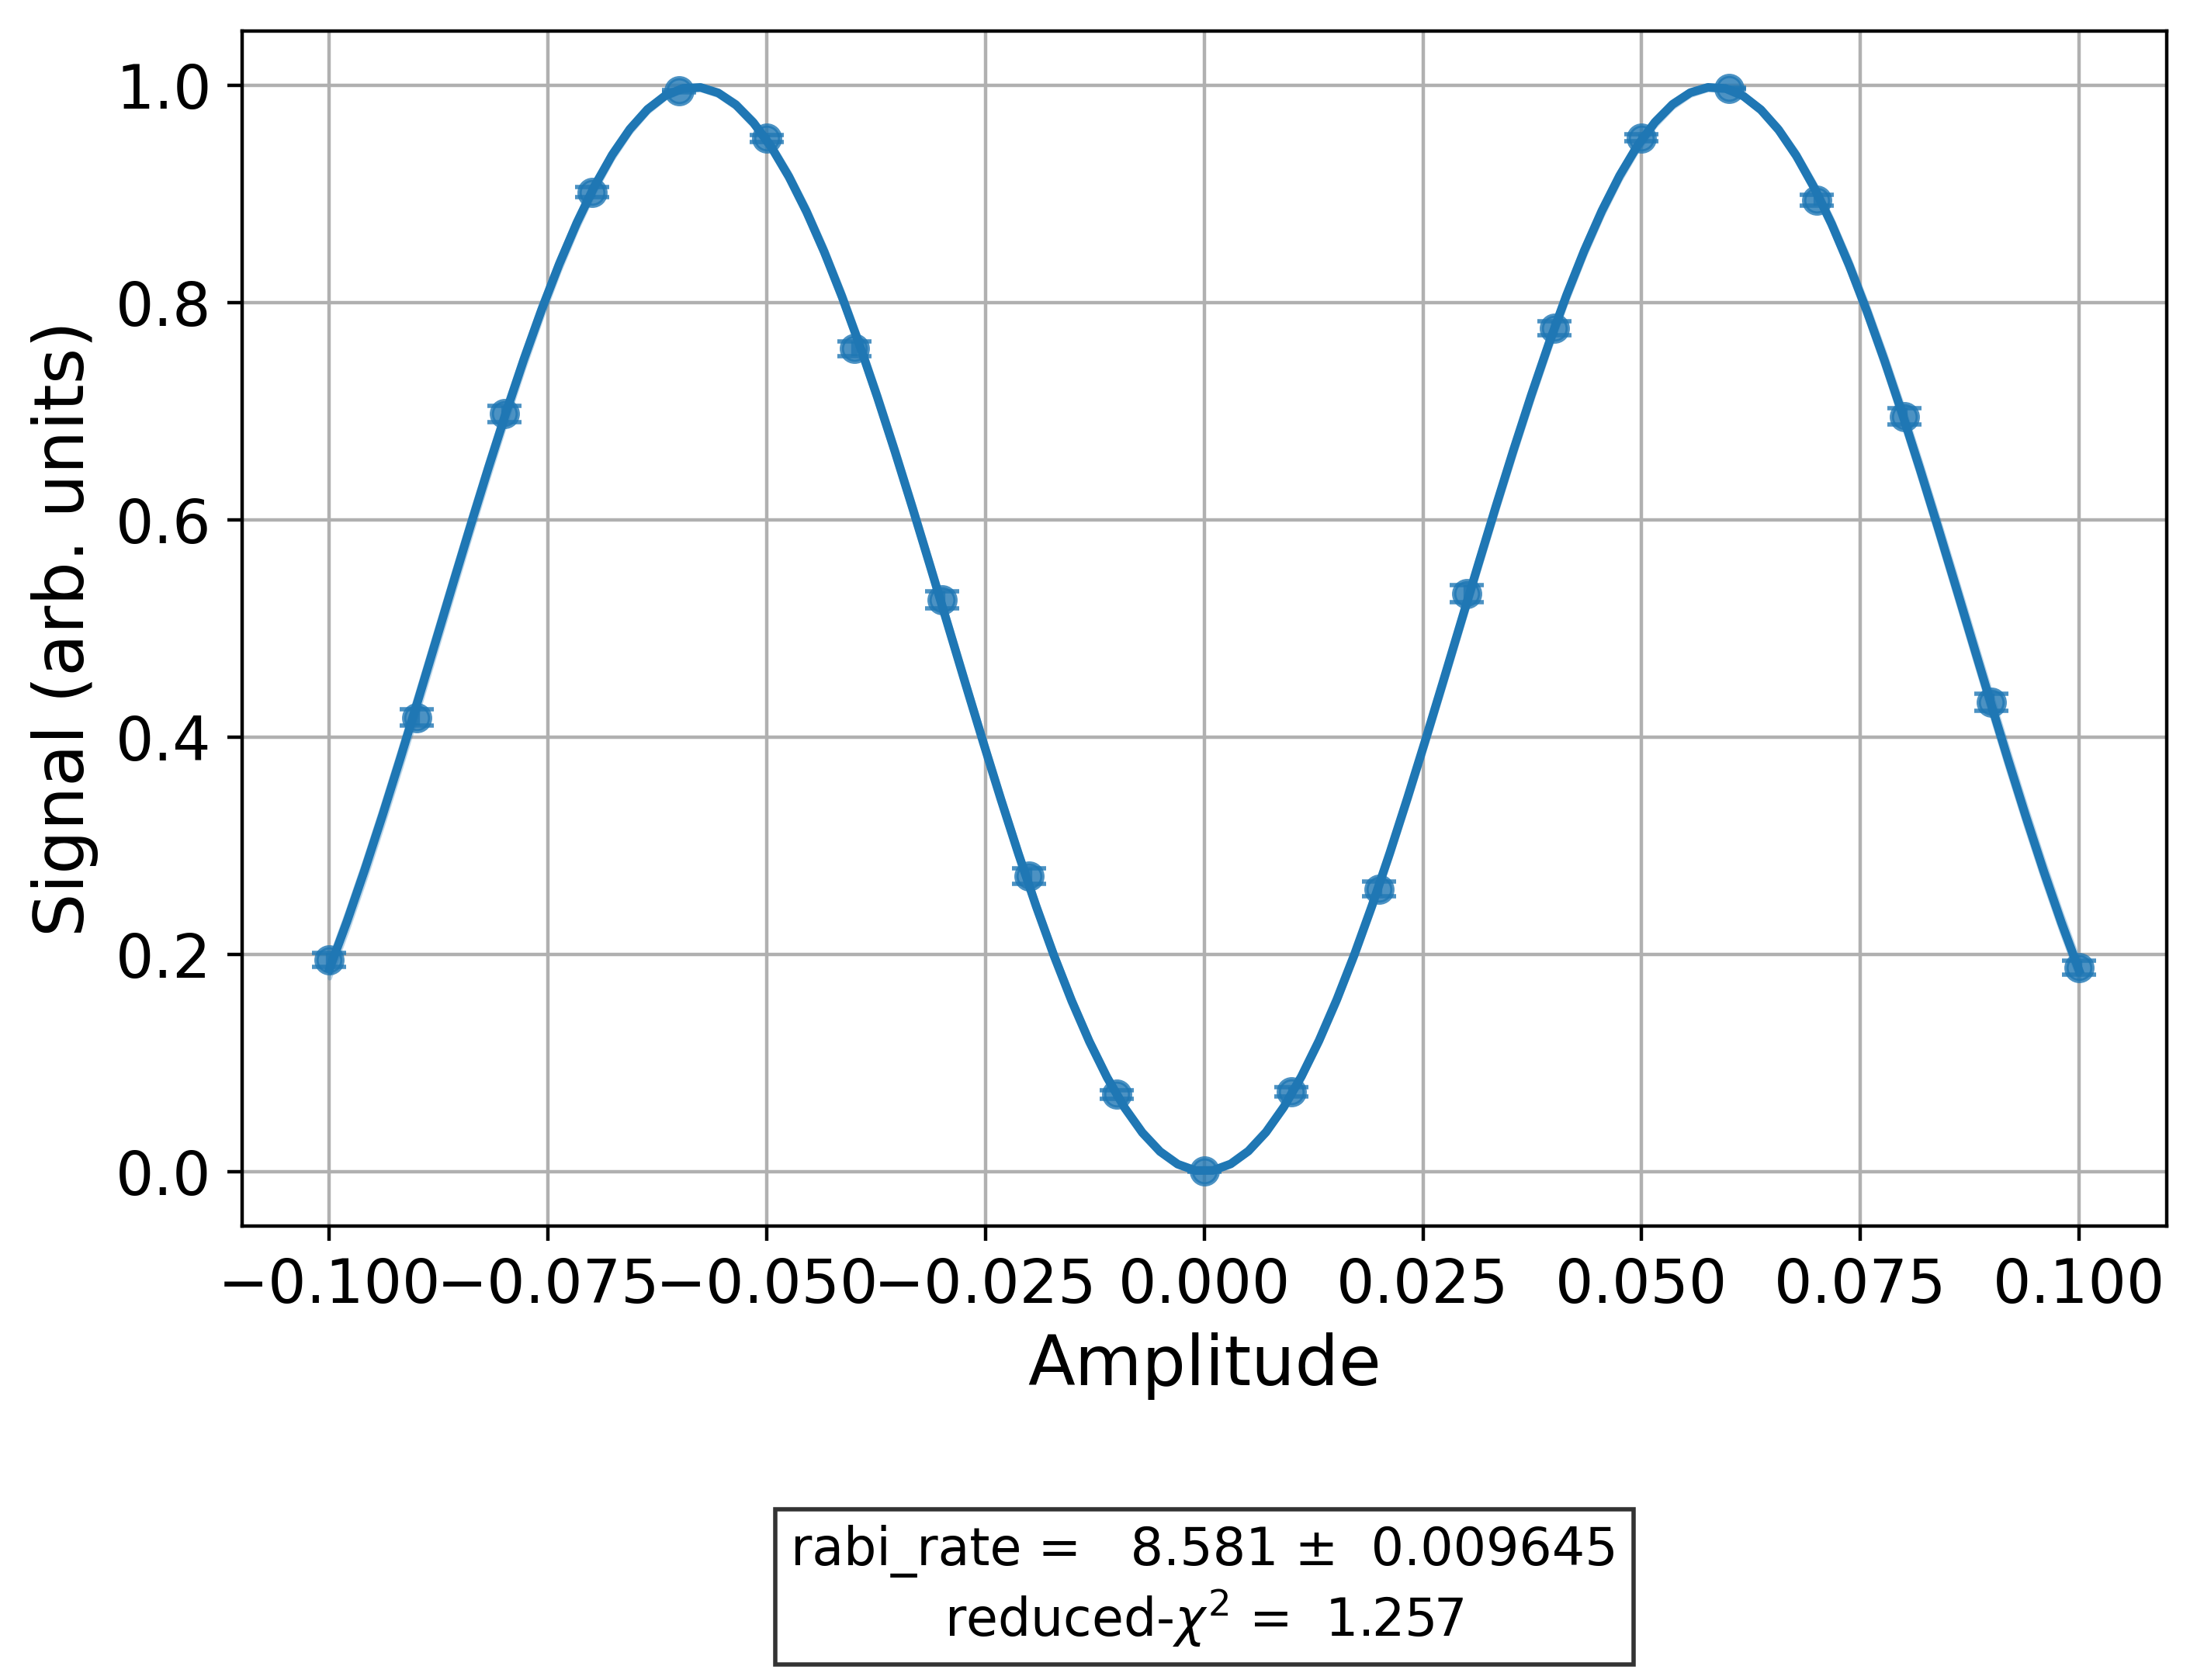

In [97]:
data_nodes = [nodes.Probability(outcome="1")]
count_processor = DataProcessor("counts", data_nodes)
exp.analysis.set_options(data_processor=count_processor)

exp_data = exp.run(meas_level=2).block_for_results()

display(exp_data.figure(0))